### 1. Data Review & Cleaning

#### 1.1. Initial review - remove redundant columns, standardize column names

In [63]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify  # to draw treemap in matplotlib

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.special import inv_boxcox       # to use absolute value
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Read dataset
data = pd.read_csv("fifa21_male2.csv")

/home/sabina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Have a quick look at the data:
data.head()

,ID,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,Club Logo,Flag Photo,POT,Team & Contract,Height,Weight,foot,Growth,Joined,Loan Date End,Value,Wage,Release Clause,Contract,Attacking,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending,Marking,Standing Tackle,Sliding Tackle,Goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,W/F,SM,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,Gender
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,https://cdn.sofifa.com/teams/55/light_60.png,https://cdn.sofifa.com/flags/it.png,69,Udinese 2008 ~ 2016,"6'0""",181lbs,Left,0,"Jul 1, 2008",NaN,€625K,€7K,€0,2008 ~ 2016,313,75,50,59,71,58.0,338,73,65.0,60,69,71,347,68,74,68.0,69,68.0,347,74,68.0,69,68,68,320,72,69.0,63.0,66.0,50,NaN,208,70,69,69.0,56,14,5,15,10,12,1929,408,3 ★,2★,Medium,High,2 ★,71,59,70,71,68,69,4,65+0,65+0,65+0,68+0,67+0,67+0,67+0,68+0,68+0,68+0,68+0,69+0,69+0,69+0,69+0,69+0,71+-2,70+-1,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,https://cdn.sofifa.com/teams/2013/light_60.png,https://cdn.sofifa.com/flags/es.png,71,KAS Eupen 2014 ~ 2019,"5'10""",143lbs,Right,0,"Jul 19, 2014",NaN,€600K,€7K,€1.1M,2014 ~ 2019,337,68,64,61,76,68.0,369,69,79.0,79,71,71,305,56,50,62.0,65,72.0,324,75,54.0,64,60,71,362,71,71.0,72.0,73.0,75,79.0,153,70,43,40.0,56,9,12,13,11,11,1906,385,4 ★,3★,Medium,Medium,1 ★,53,69,73,69,58,63,4,67+1,67+1,67+1,67+0,68+0,68+0,68+0,67+0,70+1,70+1,70+1,68+1,70+1,70+1,70+1,68+1,62+1,66+1,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,https://cdn.sofifa.com/teams/1800/light_60.png,https://cdn.sofifa.com/flags/gb-eng.png,71,Coventry City 2016 ~ 2020,"5'9""",161lbs,Right,0,"Jan 7, 2016",NaN,€1.1M,€15K,€0,2016 ~ 2020,337,80,64,41,77,75.0,387,79,84.0,77,69,78,295,48,42,71.0,59,75.0,284,72,58.0,29,56,69,317,69,39.0,69.0,74.0,66,NaN,99,35,34,30.0,51,9,6,13,16,7,1770,354,4 ★,4★,Medium,Low,2 ★,45,68,76,77,36,52,11,64+0,64+0,64+0,70+0,69+0,69+0,69+0,70+0,71+0,71+0,71+0,68+0,66+0,66+0,66+0,68+0,52+0,54+0,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,https://cdn.sofifa.com/teams/106/light_60.png,https://cdn.sofifa.com/flags/tt.png,82,Sunderland 2009,"5'11""",165lbs,Right,14,NaN,NaN,€0,€0,€0,2009,264,54,70,60,80,NaN,255,68,NaN,46,64,77,176,59,62,NaN,55,NaN,239,63,NaN,51,66,59,271,59,70.0,72.0,NaN,70,NaN,75,34,41,NaN,68,5,21,64,21,21,1348,369,3 ★,1★,NaN,NaN,1 ★,61,66,66,69,47,60,3,67+0,67+0,67+0,66+0,67+0,67+0,67+0,66+0,70+0,70+0,70+0,66+0,68+0,68+0,68+0,66+0,56+0,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,https://cdn.sofifa.com/teams/101146/light_60.png,https://cdn.sofifa.com/flags/es.png,81,Vissel Kobe 2018 ~ 2021,"5'7""",150lbs,Right,0,"Jul 16, 2018",NaN,€5.5M,€12K,€7.2M,2018 ~ 2021,367,75,69,54,90,79.0,408,85,80.0,70,83,90,346,61,56,79.0,75,75.0,297,67,40.0,58,62,70,370,58,70.0,78.0,93.0,71,89.0,181,68,57,56.0,45,6,13,6,13,7,2014,420,4 ★,4★,High,Medium,4 ★,58,70,85,85,63,59,149,72+3,72+3,72+3,79+0,79+0,79+0,79+0,79+0,82+-1,82+-1,82+-1,79+2,81+0,81+0,81+0,79+2,70+3,73+3,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


We notice immediately that the columns `Player Photo`, `Club Logo`, and `Flag Photo` contain *sofifa* links, which will not help in the current analysis, so we can drop them.

In [6]:
data.drop(['Player Photo', 'Club Logo', 'Flag Photo'], axis=1, inplace=True)

We also notice there is an ID column which we can use as our index column, after ensuring it doesn't have any duplicate values:

In [7]:
print(len(data['ID'].unique())/data.shape[0]) # equal to 1, so no duplicates

1.0


In [8]:
data.set_index('ID', inplace=True, drop=True)

We will also remove the `Name` column, as it's unlikely to be relevant to our analysis and store it in a different dataframe for future reference.

In [9]:
names = data['Name']
data.drop('Name', axis=1, inplace=True)

We also notice there are many columns names which are abbreviations - so we will rename those to the full name for clarity. To do so, we are using a `.csv` file with the abbreviations and their corresponding meaning, as seen on the *sofifa* website. Alongside, we will also standardize the column names:

In [10]:
# Change capitalization to lowercase and replace spaces with underscores:
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(" ", "_")

In [11]:
# Read positions.csv into dataframe
positions = pd.read_csv('positions.csv', header=None, index_col=0)

# Change dataframe to series and then dictionary so it can be used to rename columns:
positions = positions.squeeze().to_dict()

# Change column names:
for column in data.columns:
    if column in positions:
        data.rename(columns=positions, inplace=True)

Now, we can quickly check which columns have more than 75% null values, so we can discard them from our analysis:

In [12]:
def check_null_values(df, threshold=75):
    nulls_percentage = {}
    for column in df.columns:
        number_of_nulls = df[column].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[0], 1)
        if null_percentage >= threshold:
            nulls_percentage[column] = null_percentage
    return nulls_percentage

check_null_values(data)

{'loan_date_end': 94.7}

In [13]:
# As `loan_date_end` has mostly `NaN` values, we can discard it:
data.drop('loan_date_end', axis=1, inplace=True)

To get a sense of the amount of null values in our data, we can check the maximum percentage of `NaN` values in the dataframe:

In [14]:
def max_nulls(df):
    nulls_percentage = []
    for column in df.columns:
        number_of_nulls = df[column].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[0], 1)
        nulls_percentage.append(null_percentage)
    return max(nulls_percentage)

max_nulls(data)

2.5

Given the maximum amount of nulls is low (2.5%), we can continue with our initial review and get back to replacing null values later. 

Next, we'll review the number of unique values per column and ensure there are no columns with one value only, as they will not add any value to the analysis:

In [15]:
def check_unique_values(df):
    single_value_columns = []
    for column in df:
        if len(df[column].unique()) == 1:
            single_value_columns.append(column)
    return single_value_columns

check_unique_values(data)

['gender']

In [16]:
# Check the unique values in the gender column
data['gender'].unique()

array(['Male'], dtype=object)

In [17]:
# Remove the gender column as the data shows only male players
data.drop('gender', axis=1, inplace=True)

After looking once more at the data, we observe that the `team_&_contract` column seems to have similar information to the `club` & `contract` columns, so we might be able to remove it too. However, we first have to check our assumption is correct.

In [18]:
# Create a joined column to compare to the team & contract column
for i in range(0, data.shape[0]):
    if data['contract'].iloc[i] == np.nan:
        data['contract'].iloc[i] = ' '
    if data['club'].iloc[i] == np.nan:
        data['club'].iloc[i] = ' '

data['club_&_contract'] = data['club'] + ' ' + data['contract']

In [19]:
# Check if columns are identical
data['club_&_contract'].equals(data['team_&_contract'])

False

In [20]:
# As the columns are not identical, we'll extract the non-identical values to a dataframe to check them
def check_identical_columns(col1, col2, df):
    diff_values = pd.DataFrame({col1:[], col2:[]})

    for i in range(0, df.shape[0]):
        if df[col1].iloc[i] == df[col2].iloc[i]:
            continue
        else:
            diff_values.loc[len(diff_values.index)] = [df[col1].iloc[i], df[col2].iloc[i]]

    return diff_values       
            
diff_values = check_identical_columns(col1='club_&_contract', col2='team_&_contract', df=data)        

# diff_values

We notice two things:
- the `club_&_contract` column has null values, whereas the `team_&_contract` column doesn't
* the `club_&_contract` rows that are non-identical also contain the country that the club belongs to

As the number of values containing the country are low compared to the number of rows in the dataframe, we'll quickly check if the null values come from the `club` and / or `contract` column to see if we can discard the `team_&_contract` column:

In [21]:
# Check the rows with null values
diff_values[diff_values['club_&_contract'].isna()]

# Check if the nulls come from the contract or club columns:
print(data['contract'].isna().sum())
print(data['club'].isna().sum())

0
23


It seems that the null values in the `club_&_contract` column came from the `club` column. However, given that the `team_&_contract` values corresponding to those rows also contain only the contract information, we can remove it, as it doesn't provide any additional information.

In [22]:
data.drop(['team_&_contract', 'club_&_contract'], axis=1, inplace=True)

#### 1.2. Data Cleaning

##### 1.2.1. Numerical Data Cleaning

`value`, `wage`, and `release clause` columns:

In [23]:
financials = ['value', 'wage', 'release_clause']

def clean_value(i):
    x = float(i.replace(".","").replace("€","").replace("K","000").replace("M","00000"))
    return x

for column in financials:
    data[column] = data[column].apply(clean_value)

`weight` column:

In [24]:
def clean_weight(i):
    x = float(i.replace('lbs',''))
    return x

data["weight"] = data["weight"].apply(clean_weight)

`height` column:

In [25]:
def convert_height(i):
    to_cm = 2.54
    x = i.replace("'"," ")
    x2 = x.replace('"','') # need to do it in two parts 
                           # because of different quote used 
                           # for inch and foot 
    y = x2.split()
    height = round(((float(y[0])*12)+float(y[1]))*to_cm,0)
    return height

data['height'] = data['height'].apply(convert_height)
data['height']

ID
2         183.0
16        178.0
27        175.0
36        180.0
41        170.0
61        173.0
80        170.0
241       178.0
244       178.0
246       170.0
249       180.0
250       183.0
330       175.0
388       188.0
488       188.0
496       188.0
570       173.0
670       193.0
684       193.0
805       190.0
1001      193.0
1040      168.0
1041      178.0
1075      175.0
1088      188.0
1109      185.0
1179      193.0
1183      175.0
1186      183.0
1198      180.0
1219      190.0
1222      180.0
1238      180.0
1256      178.0
1419      193.0
1615      185.0
1625      188.0
1668      175.0
1747      180.0
1845      175.0
2062      175.0
2147      198.0
2148      180.0
2196      190.0
2231      185.0
2492      175.0
2651      185.0
2702      180.0
2837      183.0
2956      180.0
3281      188.0
3395      165.0
3467      185.0
3484      190.0
3622      183.0
3647      188.0
3712      196.0
3922      178.0
4077      170.0
4114      178.0
4202      178.0
4233      178.0
5003 

Cleaning the positions columns, i.e. `left-striker`, `goalkeeper`, etc. :

In [26]:
def cleaning_positions(i):
    x = float(i.replace("+",".").replace("-",""))
    return x

for col in data.loc[:, 'left_striker':'goalkeeper']:
    data[col] = data[col].apply(cleaning_positions)
data.head()

,age,overall_score,nationality,club,best_overall,best_position,position,potential_score,height,weight,preferred_foot,growth,joined,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,weak_foot,skill_moves,away_win,draw_games,international_reputation,pace,shooting,passing,dribble,defend,physical,hits,left_striker,striker,right_striker,left_winger,left_forward,center_forward,right_forward,right_winger,left_attacking_midfield,center_attacking_midfield,right_attacking_midfield,left_midfielder,left_center_midfield,center_midfield,right_center_midfield,right_midfielder,left_wing_back,left_defensive_midfield,center_defensive_midfield,right_defensive_midfield,right_wing_back,left_back,left_center_back,center_back,right_center_back,right_back,goalkeeper
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,33,69,Italy,Udinese,71,LWB,LM,69,183.0,181.0,Left,0,"Jul 1, 2008",625000.0,7000.0,0.0,2008 ~ 2016,313,75,50,59,71,58.0,338,73,65.0,60,69,71,347,68,74,68.0,69,68.0,347,74,68.0,69,68,68,320,72,69.0,63.0,66.0,50,NaN,208,70,69,69.0,56,14,5,15,10,12,1929,408,3 ★,2★,Medium,High,2 ★,71,59,70,71,68,69,4,65.0,65.0,65.0,68.0,67.0,67.0,67.0,68.0,68.0,68.0,68.0,69.0,69.0,69.0,69.0,69.0,71.2,70.1,70.1,70.1,71.2,70.1,69.0,69.0,69.0,70.1,17.0
16,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,71,178.0,143.0,Right,0,"Jul 19, 2014",600000.0,7000.0,1100000.0,2014 ~ 2019,337,68,64,61,76,68.0,369,69,79.0,79,71,71,305,56,50,62.0,65,72.0,324,75,54.0,64,60,71,362,71,71.0,72.0,73.0,75,79.0,153,70,43,40.0,56,9,12,13,11,11,1906,385,4 ★,3★,Medium,Medium,1 ★,53,69,73,69,58,63,4,67.1,67.1,67.1,67.0,68.0,68.0,68.0,67.0,70.1,70.1,70.1,68.1,70.1,70.1,70.1,68.1,62.1,66.1,66.1,66.1,62.1,60.1,60.1,60.1,60.1,60.1,17.1
27,33,71,England,Coventry City,71,CAM,CAM RM RW LM,71,175.0,161.0,Right,0,"Jan 7, 2016",1100000.0,15000.0,0.0,2016 ~ 2020,337,80,64,41,77,75.0,387,79,84.0,77,69,78,295,48,42,71.0,59,75.0,284,72,58.0,29,56,69,317,69,39.0,69.0,74.0,66,NaN,99,35,34,30.0,51,9,6,13,16,7,1770,354,4 ★,4★,Medium,Low,2 ★,45,68,76,77,36,52,11,64.0,64.0,64.0,70.0,69.0,69.0,69.0,70.0,71.0,71.0,71.0,68.0,66.0,66.0,66.0,68.0,52.0,54.0,54.0,54.0,52.0,47.0,46.0,46.0,46.0,47.0,15.0
36,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,82,180.0,165.0,Right,14,NaN,0.0,0.0,0.0,2009,264,54,70,60,80,NaN,255,68,NaN,46,64,77,176,59,62,NaN,55,NaN,239,63,NaN,51,66,59,271,59,70.0,72.0,NaN,70,NaN,75,34,41,NaN,68,5,21,64,21,21,1348,369,3 ★,1★,NaN,NaN,1 ★,61,66,66,69,47,60,3,67.0,67.0,67.0,66.0,67.0,67.0,67.0,66.0,70.0,70.0,70.0,66.0,68.0,68.0,68.0,66.0,56.0,65.0,65.0,65.0,56.0,57.0,51.0,51.0,51.0,57.0,22.0
41,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,81,170.0,150.0,Right,0,"Jul 16, 2018",5500000.0,12000.0,7200000.0,2018 ~ 2021,367,75,69,54,90,79.0,408,85,80.0,70,83,90,346,61,56,79.0,75,75.0,297,67,40.0,58,62,70,370,58,70.0,78.0,93.0,71,89.0,181,68,57,56.0,45,6,13,6,13,7,2014,420,4 ★,4★,High,Medium,4 ★,58,70,85,85,63,59,149,72.3,72.3,72.3,79.0,79.0,79.0,79.0,79.0,82.1,82.1,82.1,79.2,81.0,81.0,81.0,79.2,70.3,73.3,73.3,73.3,70.3,67.3,64.3,64.3,64.3,67.3,17.3


In addition to cleaning the data within, we will also find which columns have identical scores:

In [27]:
# We'll first extract the names of the positions that have players on the right / left / center
first_position = data.columns.get_loc('left_striker') 
last_position = data.columns.get_loc('goalkeeper')

position_names = []

for i in range(first_position, last_position + 1):
    column_name = data.columns[i]
    if 'left' in column_name:
        position_names.append(column_name[5:])

print(position_names)

['striker', 'winger', 'forward', 'attacking_midfield', 'midfielder', 'center_midfield', 'wing_back', 'defensive_midfield', 'back', 'center_back']


In [28]:
# Now we'll find the groups that we'd like to check
groups = {}

for position in position_names:
    placements = []
    for i in range(first_position, last_position + 1):
        column_name = data.columns[i]
        if position in column_name:
            placements.append(column_name)
    groups[position] = placements

# Remove the extra values from the 'back' list:
groups['back'] = ['left_back', 'center_back', 'right_back']

In [29]:
# Find identical columns and store the indexes in a list to later drop
to_drop = []

for position in groups.keys():
    positions_number = len(groups[position])
    for i in range(0, positions_number):
        for j in range(i + 1, positions_number):
            column_1 = groups[position][i]
            column_2 = groups[position][j]
            if data[column_1].equals(data[column_2]):
                if column_2 not in to_drop:
                    to_drop.append(column_2)

# Drop redundant columns
data.drop(to_drop, axis=1, inplace=True)

In [30]:
# Remove the 'left_' string from the remaining columns
for column in data.columns:
    if 'left' in column:
        data.rename({column: column[5:]}, axis=1, inplace=True)

data.head()

,age,overall_score,nationality,club,best_overall,best_position,position,potential_score,height,weight,preferred_foot,growth,joined,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,weak_foot,skill_moves,away_win,draw_games,international_reputation,pace,shooting,passing,dribble,defend,physical,hits,striker,winger,forward,attacking_midfield,midfielder,center_midfield,wing_back,defensive_midfield,back,center_back,goalkeeper
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,33,69,Italy,Udinese,71,LWB,LM,69,183.0,181.0,Left,0,"Jul 1, 2008",625000.0,7000.0,0.0,2008 ~ 2016,313,75,50,59,71,58.0,338,73,65.0,60,69,71,347,68,74,68.0,69,68.0,347,74,68.0,69,68,68,320,72,69.0,63.0,66.0,50,NaN,208,70,69,69.0,56,14,5,15,10,12,1929,408,3 ★,2★,Medium,High,2 ★,71,59,70,71,68,69,4,65.0,68.0,67.0,68.0,69.0,69.0,71.2,70.1,70.1,69.0,17.0
16,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,71,178.0,143.0,Right,0,"Jul 19, 2014",600000.0,7000.0,1100000.0,2014 ~ 2019,337,68,64,61,76,68.0,369,69,79.0,79,71,71,305,56,50,62.0,65,72.0,324,75,54.0,64,60,71,362,71,71.0,72.0,73.0,75,79.0,153,70,43,40.0,56,9,12,13,11,11,1906,385,4 ★,3★,Medium,Medium,1 ★,53,69,73,69,58,63,4,67.1,67.0,68.0,70.1,68.1,70.1,62.1,66.1,60.1,60.1,17.1
27,33,71,England,Coventry City,71,CAM,CAM RM RW LM,71,175.0,161.0,Right,0,"Jan 7, 2016",1100000.0,15000.0,0.0,2016 ~ 2020,337,80,64,41,77,75.0,387,79,84.0,77,69,78,295,48,42,71.0,59,75.0,284,72,58.0,29,56,69,317,69,39.0,69.0,74.0,66,NaN,99,35,34,30.0,51,9,6,13,16,7,1770,354,4 ★,4★,Medium,Low,2 ★,45,68,76,77,36,52,11,64.0,70.0,69.0,71.0,68.0,66.0,52.0,54.0,47.0,46.0,15.0
36,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,82,180.0,165.0,Right,14,NaN,0.0,0.0,0.0,2009,264,54,70,60,80,NaN,255,68,NaN,46,64,77,176,59,62,NaN,55,NaN,239,63,NaN,51,66,59,271,59,70.0,72.0,NaN,70,NaN,75,34,41,NaN,68,5,21,64,21,21,1348,369,3 ★,1★,NaN,NaN,1 ★,61,66,66,69,47,60,3,67.0,66.0,67.0,70.0,66.0,68.0,56.0,65.0,57.0,51.0,22.0
41,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,81,170.0,150.0,Right,0,"Jul 16, 2018",5500000.0,12000.0,7200000.0,2018 ~ 2021,367,75,69,54,90,79.0,408,85,80.0,70,83,90,346,61,56,79.0,75,75.0,297,67,40.0,58,62,70,370,58,70.0,78.0,93.0,71,89.0,181,68,57,56.0,45,6,13,6,13,7,2014,420,4 ★,4★,High,Medium,4 ★,58,70,85,85,63,59,149,72.3,79.0,79.0,82.1,79.2,81.0,70.3,73.3,67.3,64.3,17.3


`weak_foot`, `skill_moves`, and `international_reputation` columns:

In [31]:
star_columns = ['weak_foot', 'skill_moves', 'international_reputation']

# Check unique values
for column in star_columns:
    print(data[column].unique())

['3 ★' '4 ★' '2 ★' '1 ★' '5 ★']
['2★' '3★' '4★' '1★' '5★']
['2 ★' '1 ★' '4 ★' '3 ★' '5 ★']


In [32]:
# Select only the first character from the string, then convert the data type to integer
# and check the operation was successful
for column in star_columns:
    data[column] = data[column].str[0]
    data[column] = pd.to_numeric(data[column], errors='raise')
    print(data[column].dtypes)

int64
int64
int64


##### 1.2.2. Categorical Data Cleaning

Change the `positions` data to the number of possible positions:

In [33]:
def clean_positions(x):
    number_of_positions = str(x).split() 
    position = len(number_of_positions) 
    return position 

data['position'] = data['position'].apply(clean_positions)

Extract the year from the `joined` column:

In [34]:
# As the end of the joined is typically represented by the last 4 characters of the 
# strings, we will extract those where possible:
def extract_year(x):
    try:
        x = int(x[-4:])
    except:
        pass
    return x

data['joined'] = data['joined'].apply(extract_year)

We will use the same function to extract the end year from the `contract` column:

In [35]:
# Explore the contract data
data['contract'].unique()

# Use extract year function to get the year
data['contract'] = data['contract'].apply(extract_year)

# Check what non-integer values remained in the column:
data['contract'].unique()

array([2016, 2019, 2020, 2009, 2021, 2012, 2014, 2011, 2013,
       'England Free', 2022, 2008, 2010, 'Free', 2007, 2017,
       'France Free', 2018, 2023, 2015, 'Australia Free',
       'Czech Republic Free', 'United States Free', 'Ivory Coast Free',
       'Bari Jun 30, 2018 On Loan', 'Jun 30, 2014 On Loan',
       'Jun 30, 2018 On Loan', 2024, 2025, 'Jun 30, 2021 On Loan',
       'Germany Free', 'Brazil Free', 'Jun 30, 2015 On Loan',
       'May 31, 2021 On Loan', 'DR Congo Free', 'Jun 30, 2019 On Loan',
       'May 31, 2018 On Loan', 'May 31, 2019 On Loan',
       'Jun 30, 2017 On Loan', 'Argentina Free',
       'CD Mirandés Jun 30, 2017 On Loan', 'Dec 31, 2020 On Loan', 1648,
       2006, 'Jun 30, 2020 On Loan', 'Jan 30, 2021 On Loan',
       'Jun 30, 2016 On Loan', 'Aug 31, 2020 On Loan',
       'Jan 1, 2021 On Loan', 'Dec 31, 2021 On Loan', 'India Free',
       'May 25, 2016 On Loan', 'Jun 1, 2021 On Loan',
       'Jan 31, 2021 On Loan', 'Jul 5, 2021 On Loan',
       'May 31, 20

The values having `On Loan` at the end mean that the player still has a contract with the club, but he's borrowed to a different team in the meantime. We can create a separate column to track the players that have been on loan:

In [36]:
def record_loans(x):
    if type(x) == str and 'On Loan' in x:
        record = 'Yes'
    else:
        record = 'No'
    return record    

data['on_loan'] = data['contract'].apply(record_loans)

# Check the operation was successful
data['on_loan'].unique()

array(['No', 'Yes'], dtype=object)

In [37]:
# We'll now remove the 'On Loan' string from the contract column to extract the year:
def clean_loans(x):
    try:
        x = int(x.replace(" On Loan", "")[-4:])
    except:
        pass
    return x    

data['contract'] = data['contract'].apply(clean_loans)

# Check the operation was successful
data['contract'].unique()

array([2016, 2019, 2020, 2009, 2021, 2012, 2014, 2011, 2013,
       'England Free', 2022, 2008, 2010, 'Free', 2007, 2017,
       'France Free', 2018, 2023, 2015, 'Australia Free',
       'Czech Republic Free', 'United States Free', 'Ivory Coast Free',
       2024, 2025, 'Germany Free', 'Brazil Free', 'DR Congo Free',
       'Argentina Free', 1648, 2006, 'India Free', 2026, 'Egypt Free',
       2028, 'Bolivia Free', 2027, 'United Arab Emirates Free'],
      dtype=object)

We notice the only odd values left are the ones looking like *Country Free* and the *1648*, so we will look at how many rows have these type of values:

In [38]:
odd_ones_out = []

for value in data['contract']:
    if type(value) == str and 'Free' in value:
        odd_ones_out.append(value)
    elif value == 1648:
        odd_ones_out.append(value)

len(odd_ones_out)

342

As there are very few odd values compared to the number of rows in the dataset, we can replace them with nulls:

In [39]:
def clean_odds(x):
    if x in odd_ones_out:
        x = np.nan
    return x    

data['contract'] = data['contract'].apply(clean_odds)

# Rename column to end_contract
data.rename({'contract': 'end_contract'}, axis=1, inplace=True)

# Check the operation was successful
data['end_contract'].unique()

array([2016., 2019., 2020., 2009., 2021., 2012., 2014., 2011., 2013.,
         nan, 2022., 2008., 2010., 2007., 2017., 2018., 2023., 2015.,
       2024., 2025., 2006., 2026., 2028., 2027.])

`nationality` column:

In [40]:
data["nationality"] = data["nationality"].apply(lambda x: "Congo" if str(x).startswith("DR")
                                                 else "North Korea" if str(x).endswith("DPR")
                                                 else "China" if str(x).endswith("PR")
                                                 else str(x).replace("&amp;","and") if "&amp;" in x
                                                 else x)

In [41]:
data.head()

,age,overall_score,nationality,club,best_overall,best_position,position,potential_score,height,weight,preferred_foot,growth,joined,value,wage,release_clause,end_contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,weak_foot,skill_moves,away_win,draw_games,international_reputation,pace,shooting,passing,dribble,defend,physical,hits,striker,winger,forward,attacking_midfield,midfielder,center_midfield,wing_back,defensive_midfield,back,center_back,goalkeeper,on_loan
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,33,69,Italy,Udinese,71,LWB,1,69,183.0,181.0,Left,0,2008.0,625000.0,7000.0,0.0,2016.0,313,75,50,59,71,58.0,338,73,65.0,60,69,71,347,68,74,68.0,69,68.0,347,74,68.0,69,68,68,320,72,69.0,63.0,66.0,50,NaN,208,70,69,69.0,56,14,5,15,10,12,1929,408,3,2,Medium,High,2,71,59,70,71,68,69,4,65.0,68.0,67.0,68.0,69.0,69.0,71.2,70.1,70.1,69.0,17.0,No
16,37,71,Spain,KAS Eupen,70,CM,3,71,178.0,143.0,Right,0,2014.0,600000.0,7000.0,1100000.0,2019.0,337,68,64,61,76,68.0,369,69,79.0,79,71,71,305,56,50,62.0,65,72.0,324,75,54.0,64,60,71,362,71,71.0,72.0,73.0,75,79.0,153,70,43,40.0,56,9,12,13,11,11,1906,385,4,3,Medium,Medium,1,53,69,73,69,58,63,4,67.1,67.0,68.0,70.1,68.1,70.1,62.1,66.1,60.1,60.1,17.1,No
27,33,71,England,Coventry City,71,CAM,4,71,175.0,161.0,Right,0,2016.0,1100000.0,15000.0,0.0,2020.0,337,80,64,41,77,75.0,387,79,84.0,77,69,78,295,48,42,71.0,59,75.0,284,72,58.0,29,56,69,317,69,39.0,69.0,74.0,66,NaN,99,35,34,30.0,51,9,6,13,16,7,1770,354,4,4,Medium,Low,2,45,68,76,77,36,52,11,64.0,70.0,69.0,71.0,68.0,66.0,52.0,54.0,47.0,46.0,15.0,No
36,36,68,Trinidad and Tobago,Sunderland,70,ST,1,82,180.0,165.0,Right,14,NaN,0.0,0.0,0.0,2009.0,264,54,70,60,80,NaN,255,68,NaN,46,64,77,176,59,62,NaN,55,NaN,239,63,NaN,51,66,59,271,59,70.0,72.0,NaN,70,NaN,75,34,41,NaN,68,5,21,64,21,21,1348,369,3,1,NaN,NaN,1,61,66,66,69,47,60,3,67.0,66.0,67.0,70.0,66.0,68.0,56.0,65.0,57.0,51.0,22.0,No
41,36,81,Spain,Vissel Kobe,82,CAM,2,81,170.0,150.0,Right,0,2018.0,5500000.0,12000.0,7200000.0,2021.0,367,75,69,54,90,79.0,408,85,80.0,70,83,90,346,61,56,79.0,75,75.0,297,67,40.0,58,62,70,370,58,70.0,78.0,93.0,71,89.0,181,68,57,56.0,45,6,13,6,13,7,2014,420,4,4,High,Medium,4,58,70,85,85,63,59,149,72.3,79.0,79.0,82.1,79.2,81.0,70.3,73.3,67.3,64.3,17.3,No


We will also check if there is any numerical data still stored as an object:

In [42]:
for col in data.columns:
    print(col, ":", data[col].dtypes)

age : int64
overall_score : int64
nationality : object
club : object
best_overall : int64
best_position : object
position : int64
potential_score : int64
height : float64
weight : float64
preferred_foot : object
growth : int64
joined : float64
value : float64
wage : float64
release_clause : float64
end_contract : float64
attacking : int64
crossing : int64
finishing : int64
heading_accuracy : int64
short_passing : int64
volleys : float64
skill : int64
dribbling : int64
curve : float64
fk_accuracy : int64
long_passing : int64
ball_control : int64
movement : int64
acceleration : int64
sprint_speed : int64
agility : float64
reactions : int64
balance : float64
power : int64
shot_power : int64
jumping : float64
stamina : int64
strength : int64
long_shots : int64
mentality : int64
aggression : int64
interceptions : float64
positioning : float64
vision : float64
penalties : int64
composure : float64
defending : int64
marking : int64
standing_tackle : int64
sliding_tackle : float64
goalkeeping 

As the `hits` column is still an object, we will change it to numerical data:

In [43]:
data['hits'] = pd.to_numeric(data['hits'], errors='coerce')

#### 1.3. Find & replace null values

In [44]:
# Check there aren't any rows with too many null values:
def check_null_values_rows(df, threshold=75):
    nulls_percentage = {}
    for index in df.index:
        number_of_nulls = df.loc[index,].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[1], 1)
        if null_percentage >= threshold:
            nulls_percentage[index] = null_percentage
    return nulls_percentage

check_null_values_rows(data)

{}

As there are no rows with more than 75% `NaN` values, we can begin replacing these values per column. Before doing so, however, we will also check the maximum amount of nulls we have in any given row:

In [45]:
def max_nulls_rows(df):
    nulls_percentage = []
    for index in df.index:
        number_of_nulls = df.loc[index,].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[1], 1)
        nulls_percentage.append(null_percentage)
    return max(nulls_percentage)

max_nulls_rows(data)

15.5

As the maximum amount of null values within a row is only ~15%, we can move on to replacing the null values in the relevant columns.

In [46]:
# Check number of null values
for col in data.columns:
    if data[col].isna().sum() != 0:
        print(col, ":", round((data[col].isna().sum()) * 100 / data.shape[0], 0),"%")

club : 0.0 %
joined : 0.0 %
end_contract : 2.0 %
volleys : 0.0 %
curve : 0.0 %
agility : 0.0 %
balance : 0.0 %
jumping : 0.0 %
interceptions : 0.0 %
positioning : 0.0 %
vision : 0.0 %
composure : 2.0 %
sliding_tackle : 0.0 %
away_win : 1.0 %
draw_games : 1.0 %
hits : 0.0 %


In [47]:
# Max left is 2% so we can safely drop the remaining NaN values:
data = data.dropna()

### 2. Exploratory Data Analysis

#### 2.1. Categorical & Discrete Numerical data

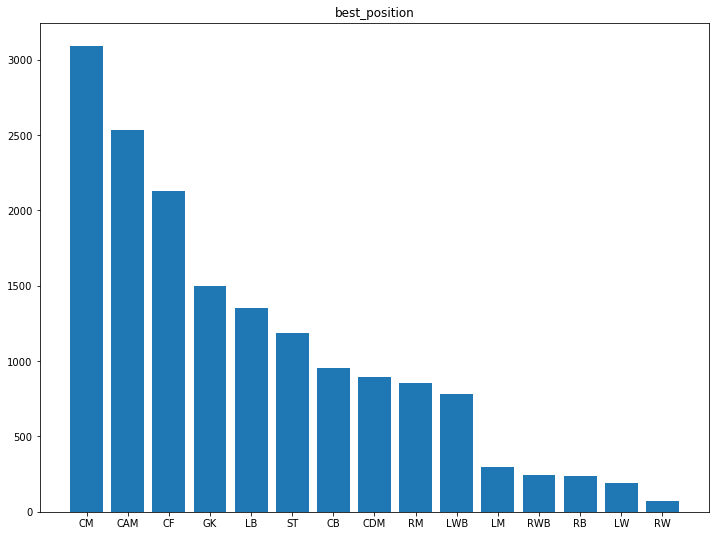

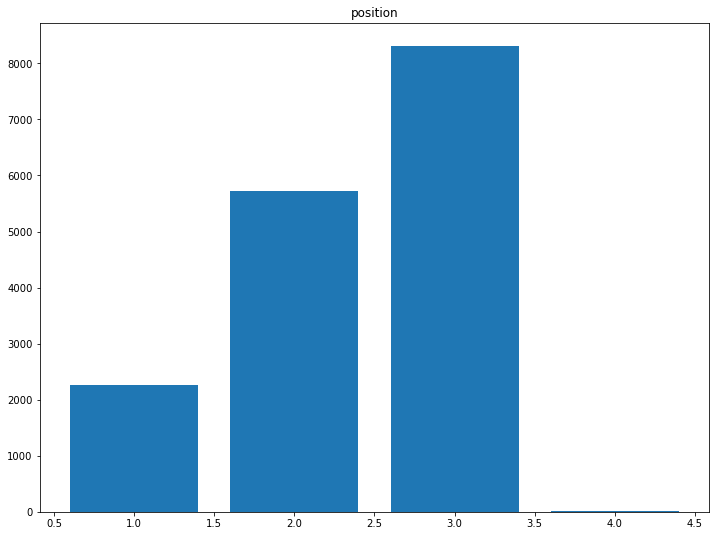

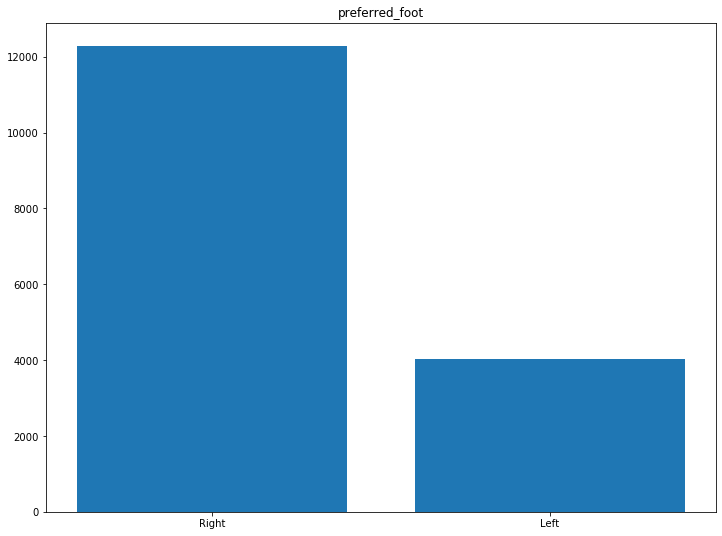

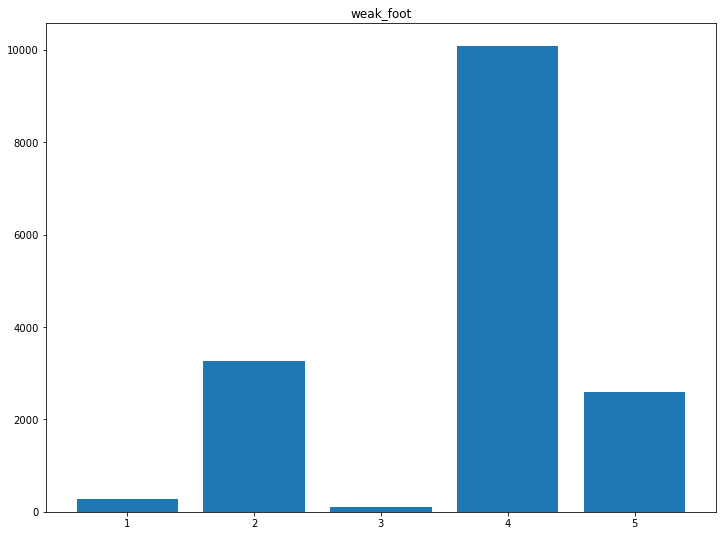

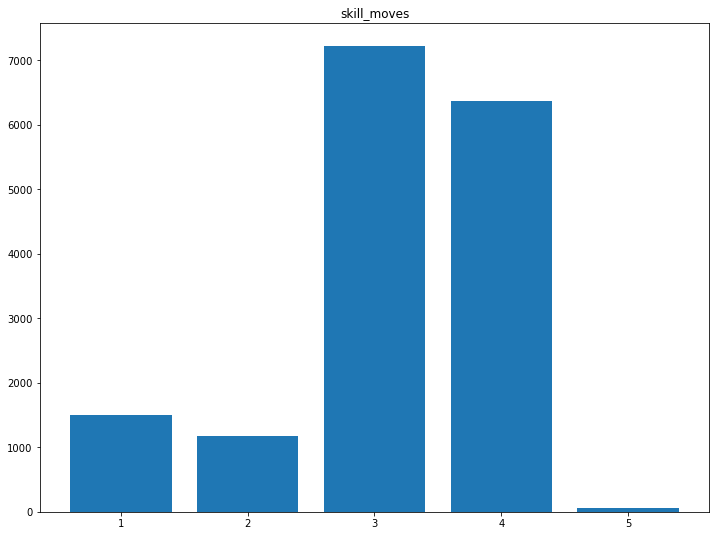

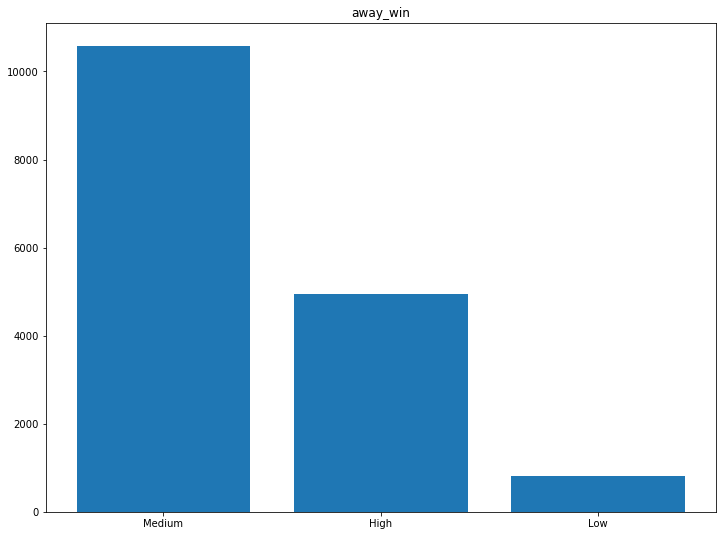

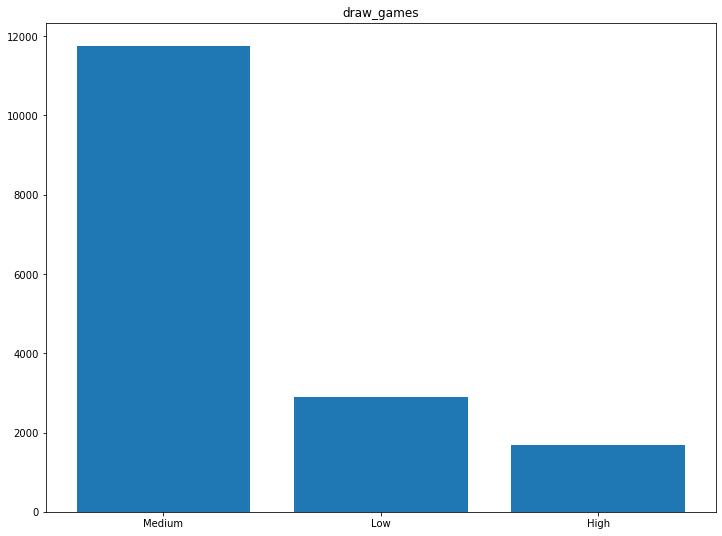

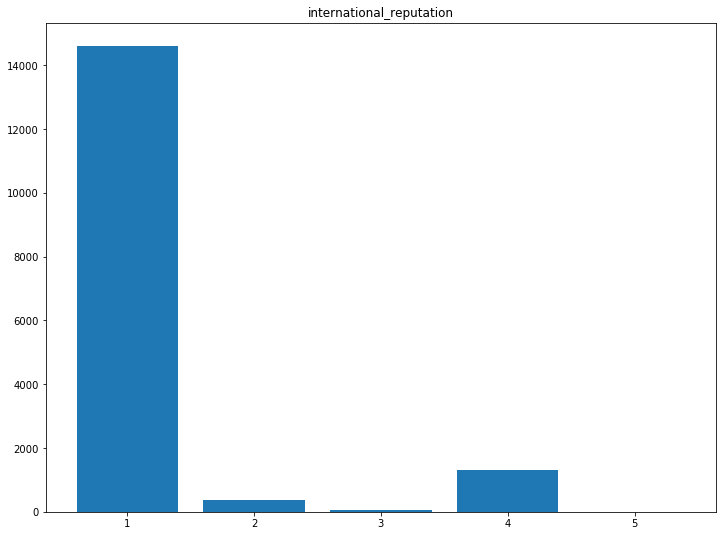

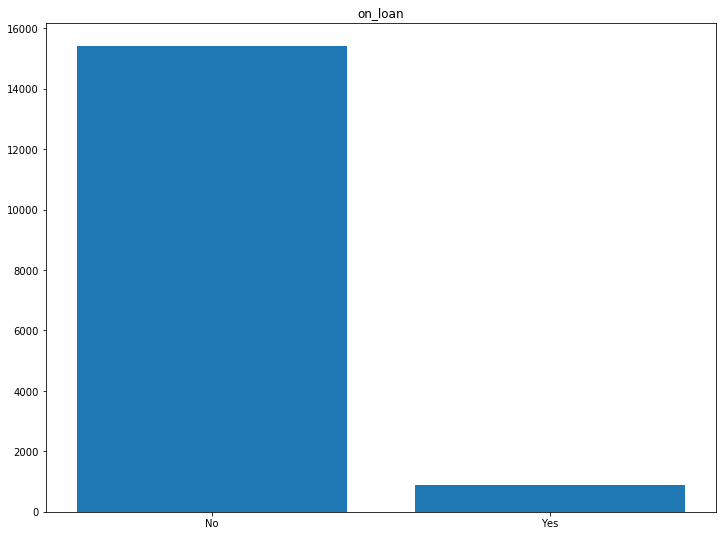

In [52]:
# Select categorical and discrete numerical data
cat_cols = []

for column in data.columns:
    if len(data[column].unique()) <= 10 or data[column].dtypes == np.object:
        cat_cols.append(column)

# Show bar plots for categorical data with few values
for column in cat_cols:
    x = data[column].unique()
    y = data[column].value_counts()
    if len(x) < 100:
        fig, ax = plt.subplots(figsize = (12, 9))
        plt.title(column)
        plt.bar(x, y)
        plt.show()

From these plots, we see that:
* most players in the dataset are in center positions (*CM*, *CAM*, *CF*)
- players' position rating is mostly from 1-3 stars
* ~ 3/4 of players prefer playing with their right-foot
- most players play relatively well with their weak foot (4-5 ratings)
* most players have a 3-4 rating for skill moves
- most players have a moderate amount of wins away from home, as well as draws
* the majority of the players in the dataset have a low international reputation
- most players play for the team they've been contracted in, rather than on loan

Given there are too many categories in the `nationality` and `club` columns, we cannot easily visualize them using (small) bar plots. However, inspired by [4m4n5's graph](https://github.com/4m4n5/fifa18-all-player-statistics) for representing nationality data, we used a treemap:

In [49]:
nationality = pd.DataFrame(data['nationality'].value_counts())
nationality.sort_values(ascending=False, inplace=True, by='nationality')
nationality.reset_index(inplace=True)
nationality.rename({'index': 'nationality', 'nationality':'number_of_players'}, axis=1, inplace=True)

In [50]:
# Rename countries with less than 10 players to 'Other' and remove columns:
other_count = 0

for i in range(0, nationality.shape[0]):
    if nationality.loc[i, 'number_of_players'] < 30:
        nationality.loc[i,'nationality'] = 'Other'
        other_count += nationality.loc[i, 'number_of_players']
        nationality.drop(i, axis=0, inplace=True)

# Add back the consolidated 'Other' column:
nationality.loc[len(nationality.index)] = ['Other', other_count]

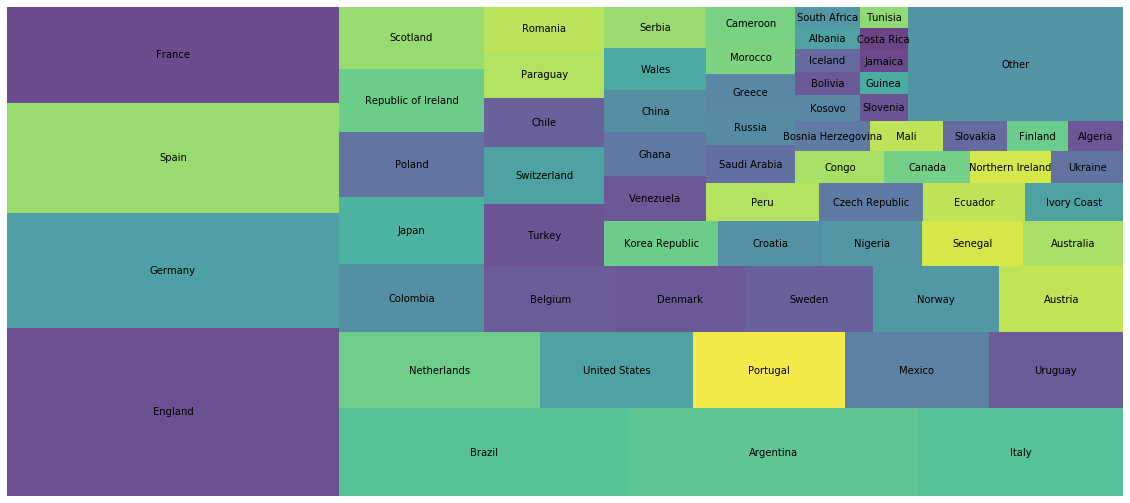

In [51]:
# Plot data
fig, ax = plt.subplots(figsize = (20, 9))
squarify.plot(sizes=nationality['number_of_players'], label=nationality['nationality'], alpha=.8)
plt.axis('off')
plt.show()

#### 2.2. Continuous numerical data

We will have a look at the overall and potential scores of the players, to get an idea of whether or not they would be collinear:

In [ ]:
# Sort the best players by overall score
best_players = data.sort_values(["overall_score"], ascending=[False])
rank = best_players[["name", "overall_score"]]
rank.head(10)

In [ ]:
# Sort the best potential players
best_pot = data.sort_values(["potential_score"], ascending=[False])
rank_2 = best_players[["name", "potential_score"]]
rank_2.head(10) # same players as sorted by overall score

In [ ]:
# Would there be any difference between players with the worst overall and potential score?
worst_players = data.sort_values(["overall_score"], ascending=[False])
rank = worst_players[["name", "overall_score"]]
rank.tail(10)

In [ ]:
worst_pot = data.sort_values(["potential_score"], ascending=[False])
rank_2 = worst_players[["name", "potential_score"]]
rank_2.tail(10) # the players are exactly the same

In [ ]:
# How many hits do the best players have?
best_hits = data.sort_values(["overall_score", "hits"], ascending=[False, False])
rank_3 = best_players[["name", "overall_score", "hits"]]
rank_3.head(3)

Now, we will have a look at the data distribution:

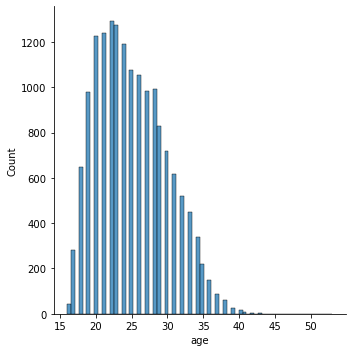

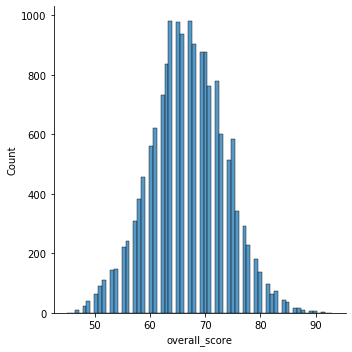

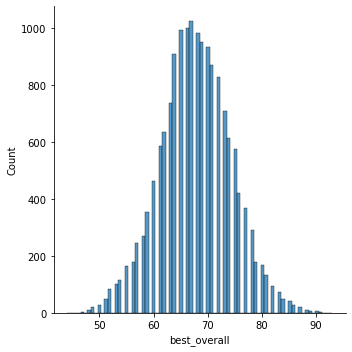

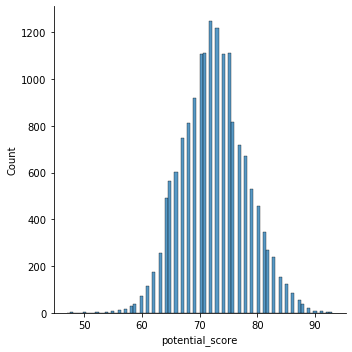

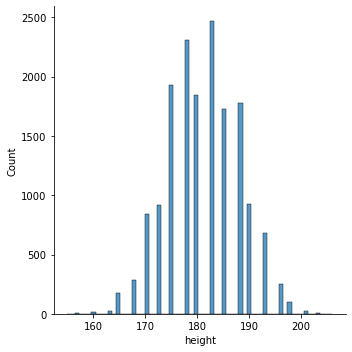

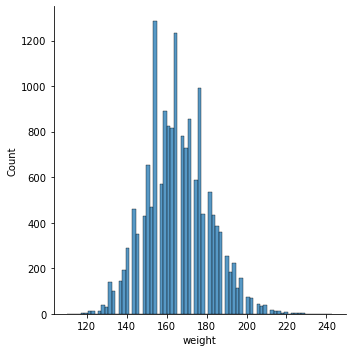

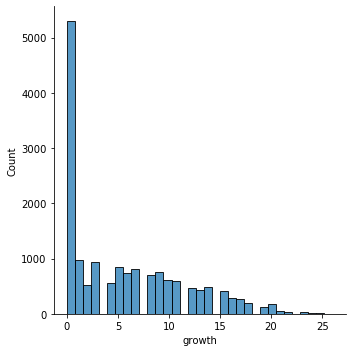

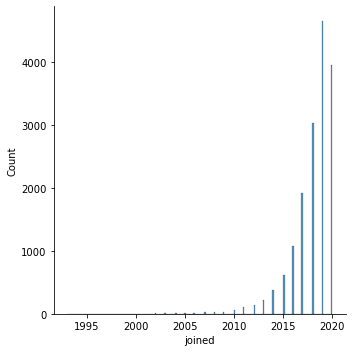

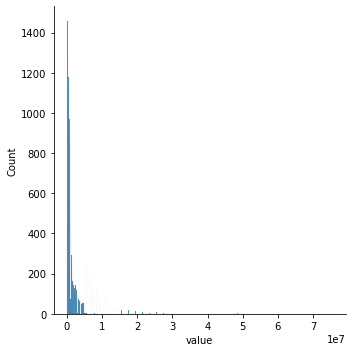

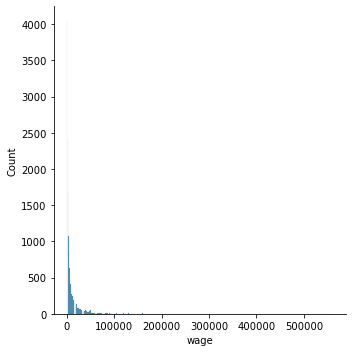

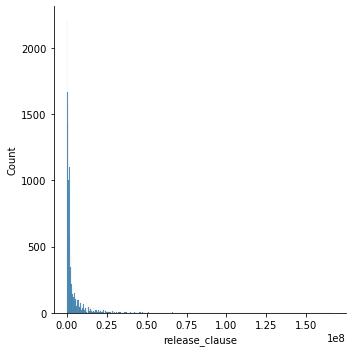

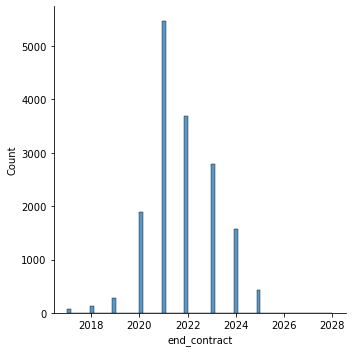

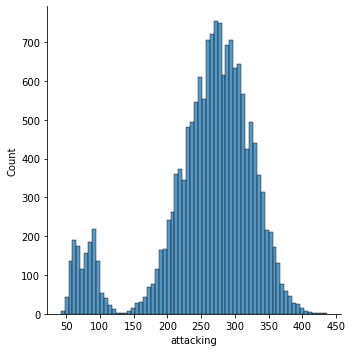

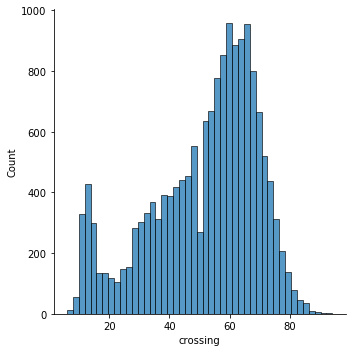

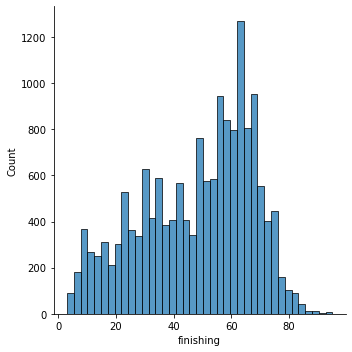

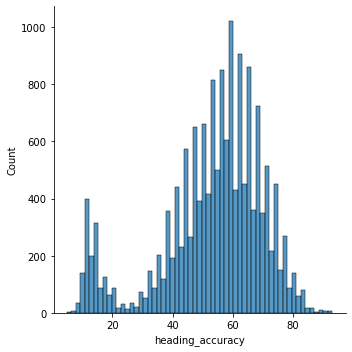

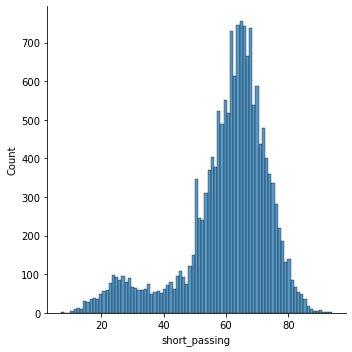

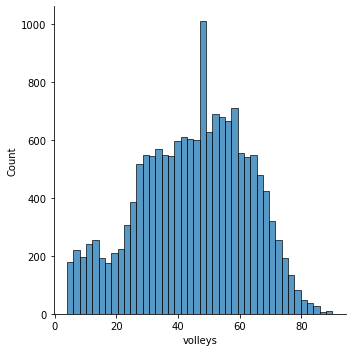

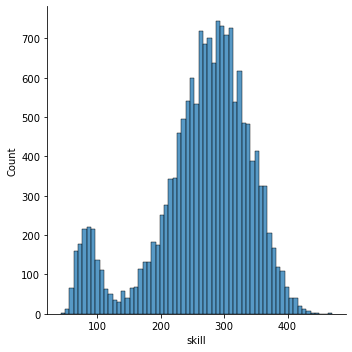

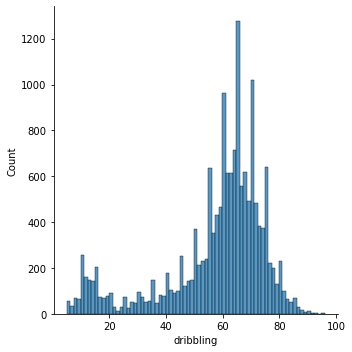

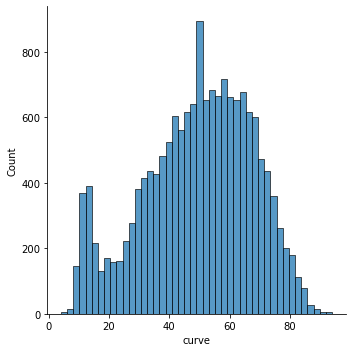

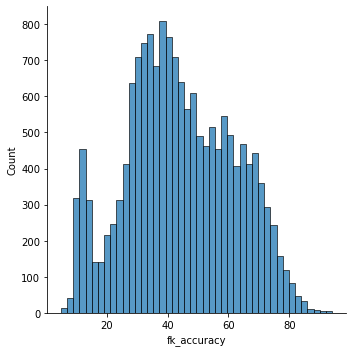

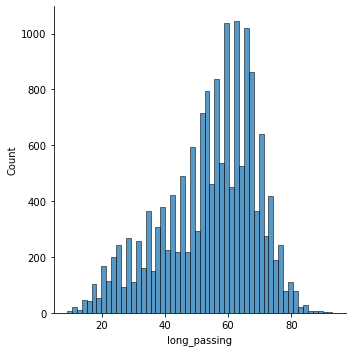

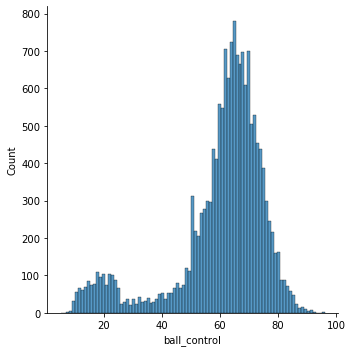

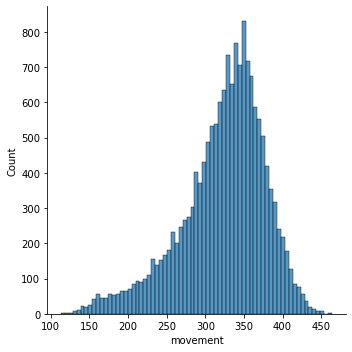

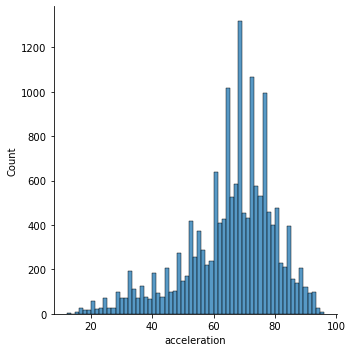

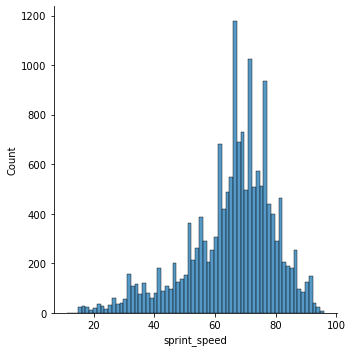

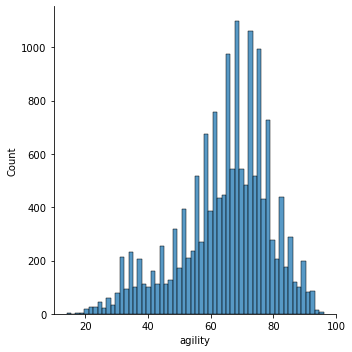

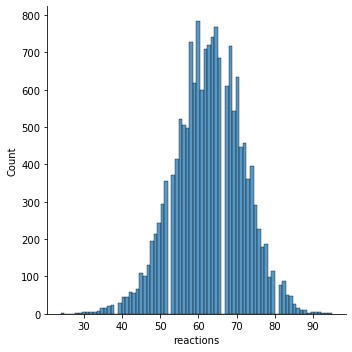

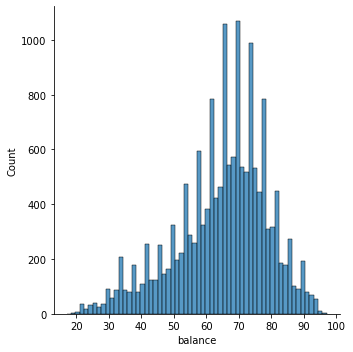

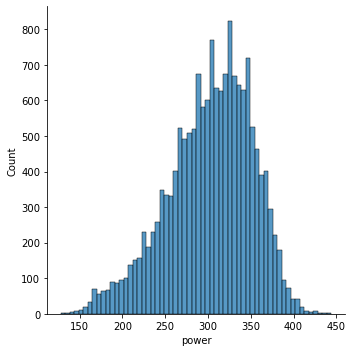

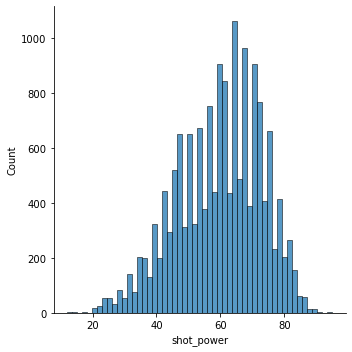

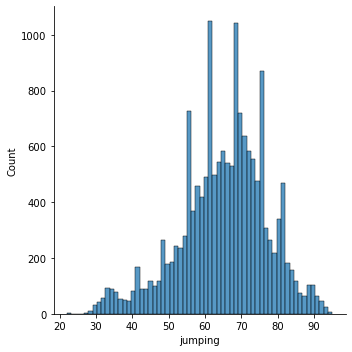

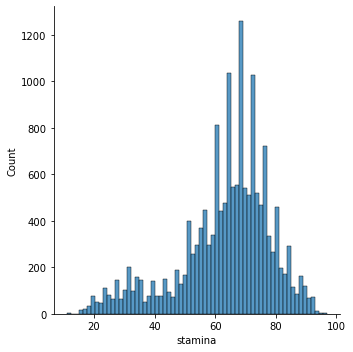

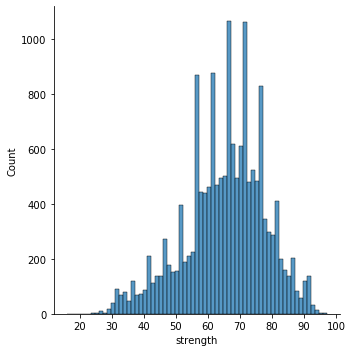

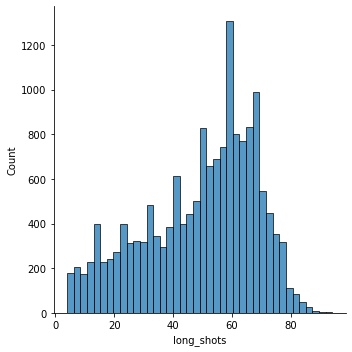

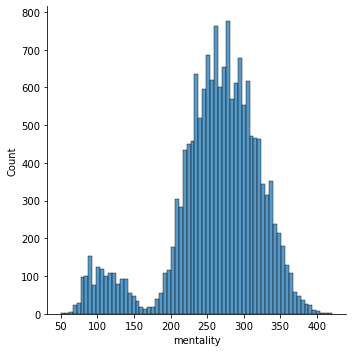

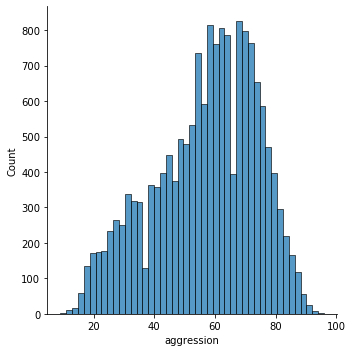

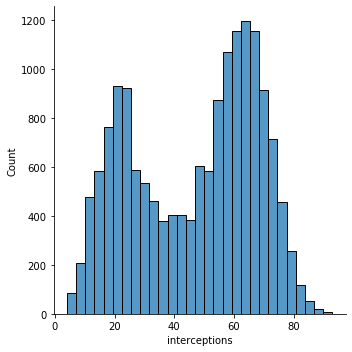

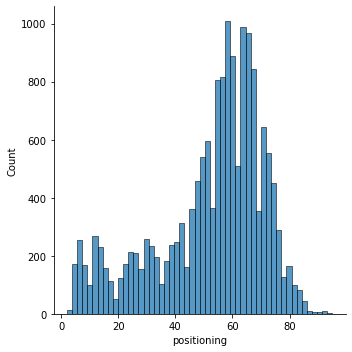

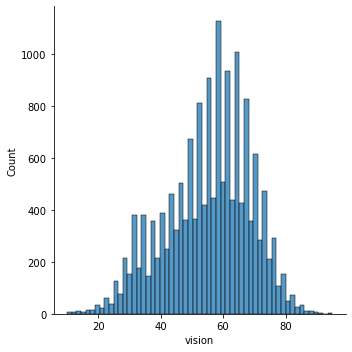

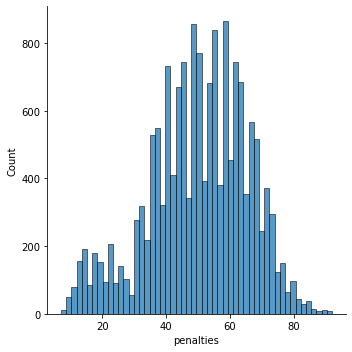

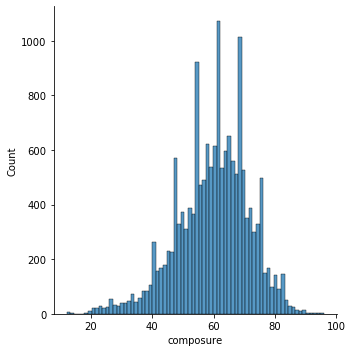

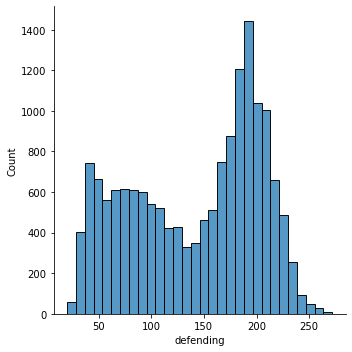

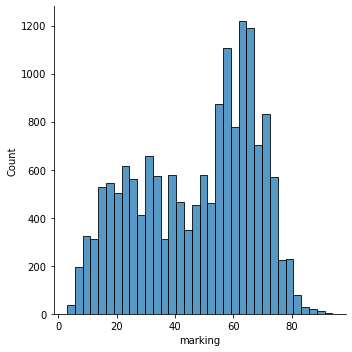

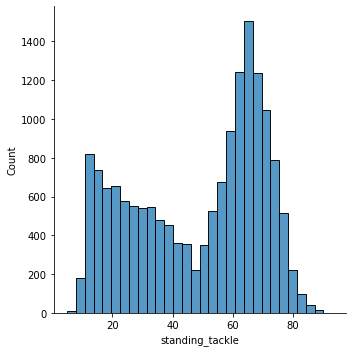

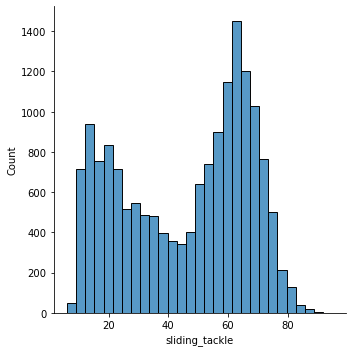

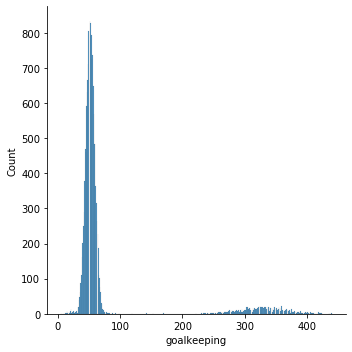

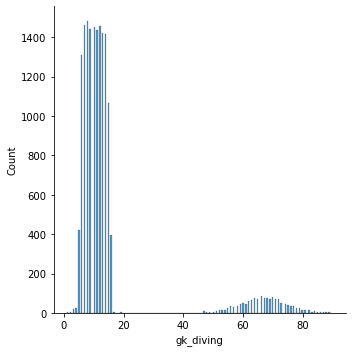

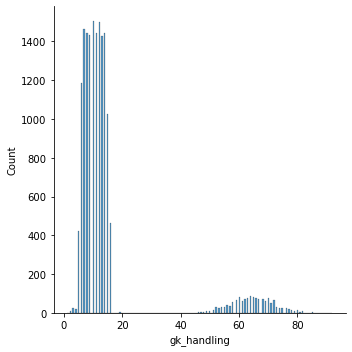

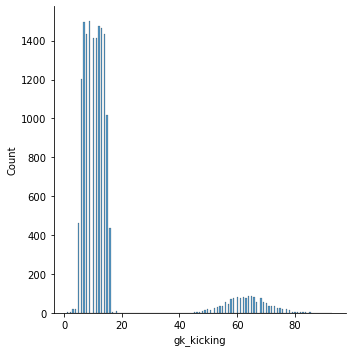

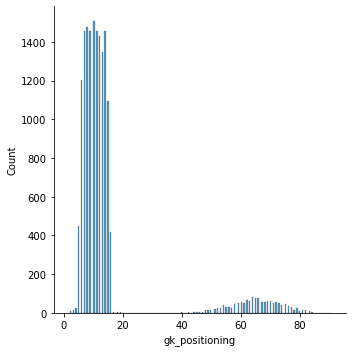

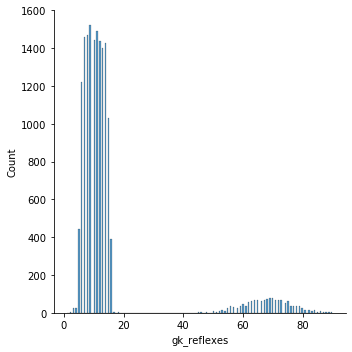

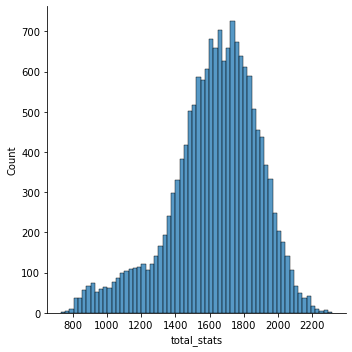

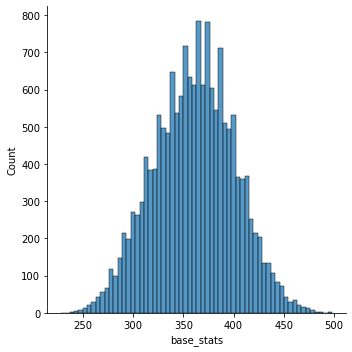

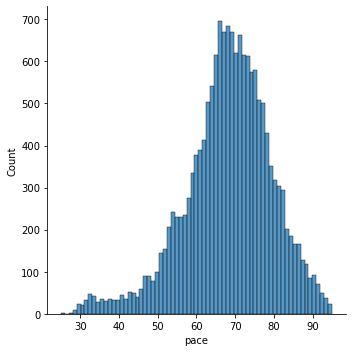

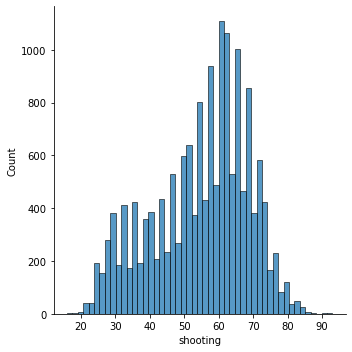

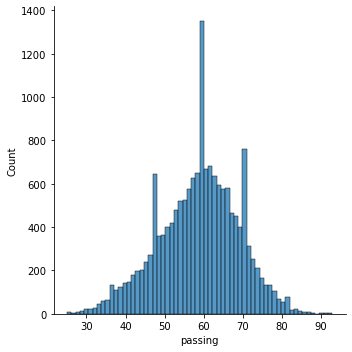

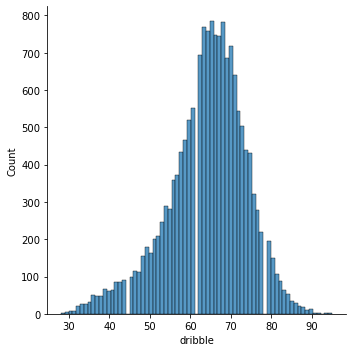

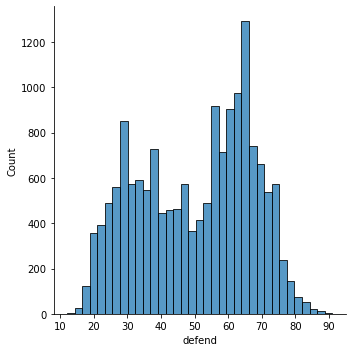

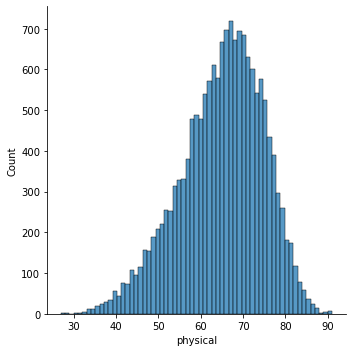

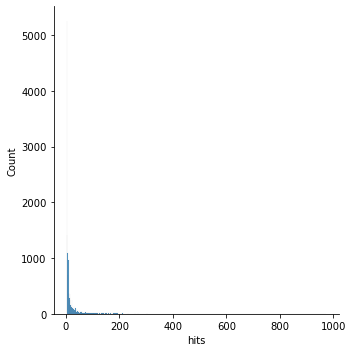

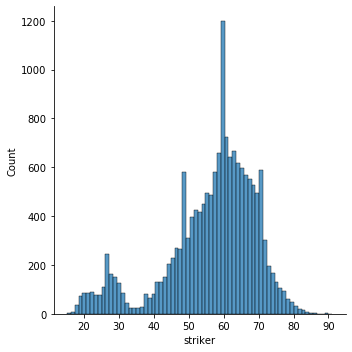

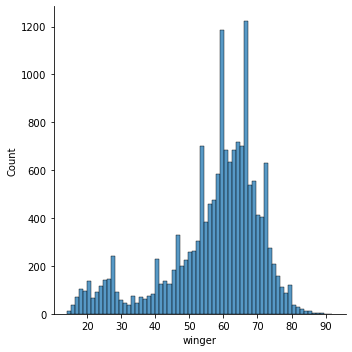

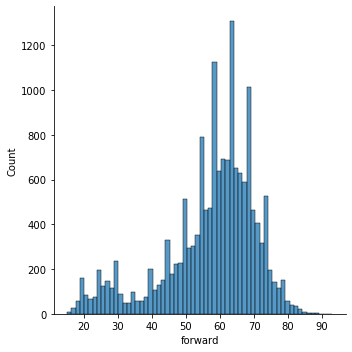

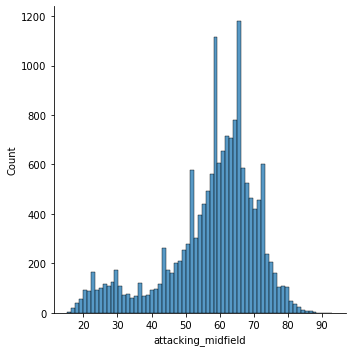

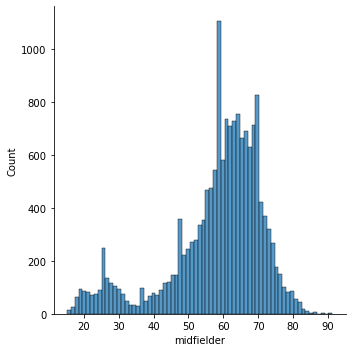

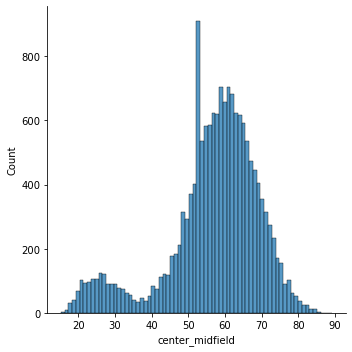

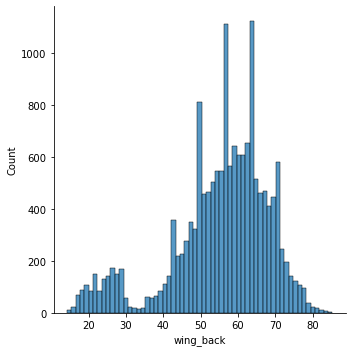

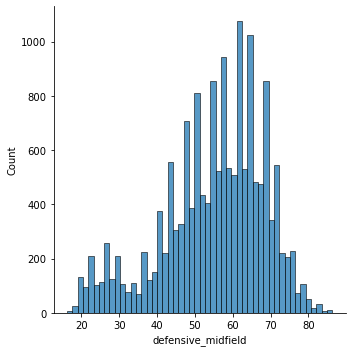

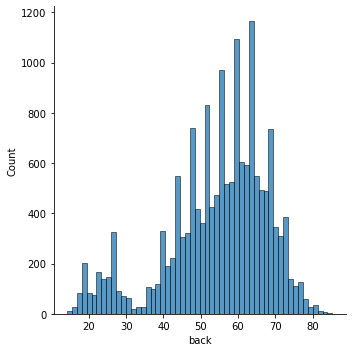

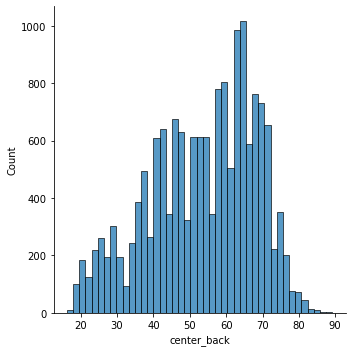

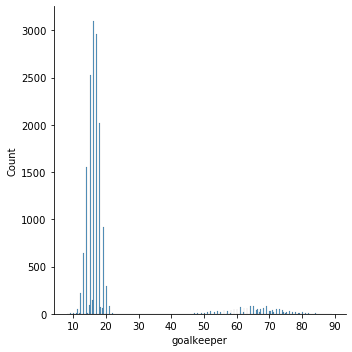

In [56]:
# Select the numerical data
num = data.select_dtypes(np.number)

# Extract the continuous numerical data and plot it
for column in num.columns:
    if len(data[column].unique()) > 10:
        sns.displot(data[column])
        plt.show()

We can see that many of the attributes are normally distributed, except for the `wage`, `value`, `release_clause`, `hits`, and `joined` columns, which are heavily skewed towards lower values. We'll also represent the data using boxplots, to get an image of the amount of outliers present:

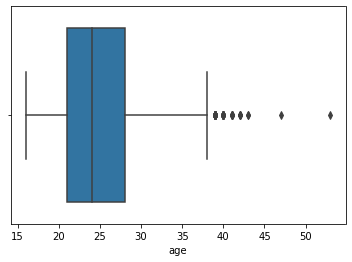

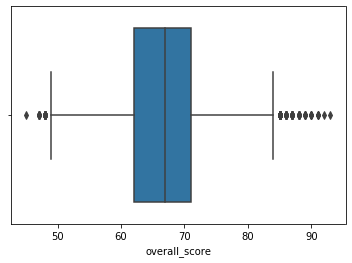

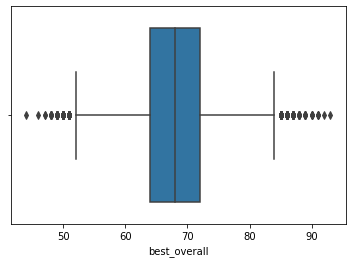

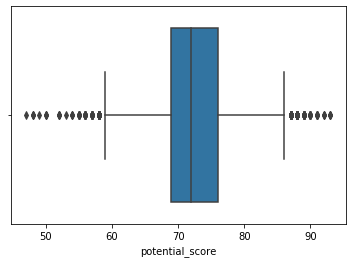

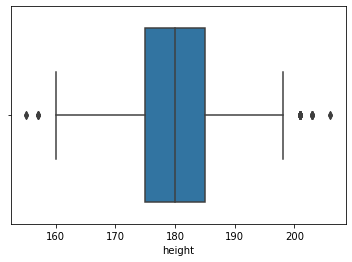

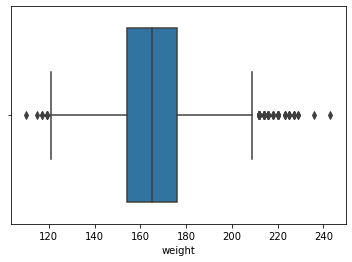

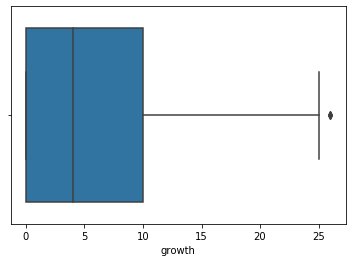

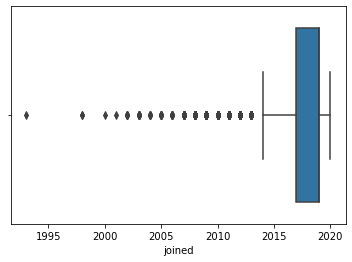

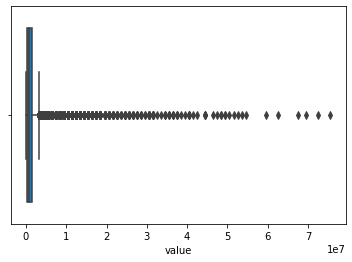

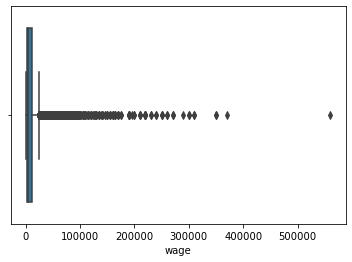

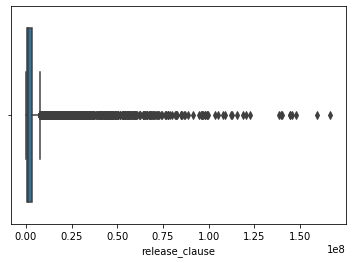

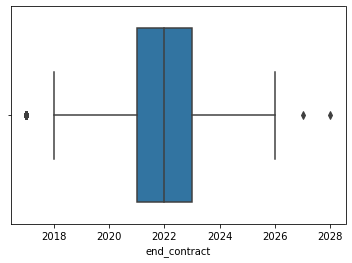

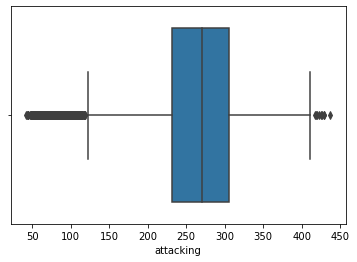

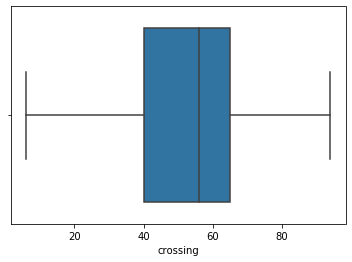

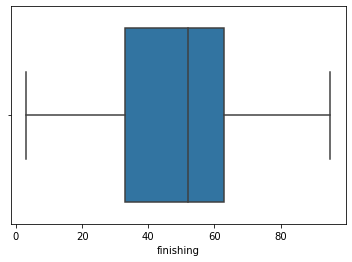

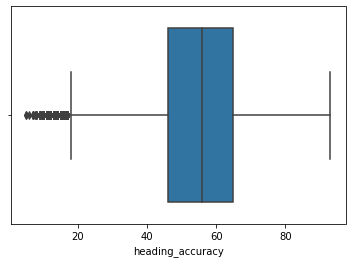

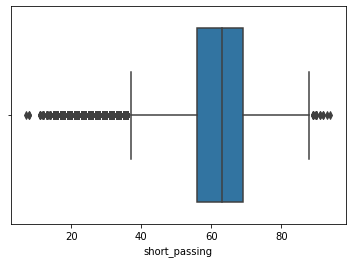

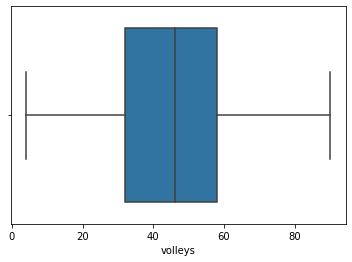

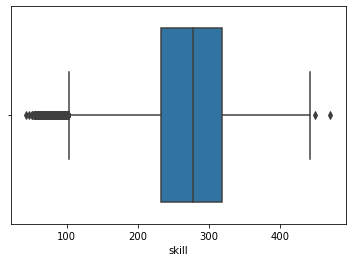

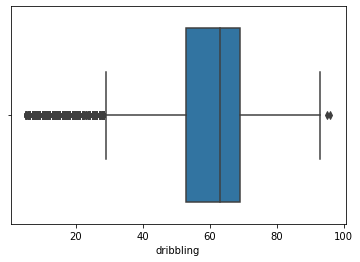

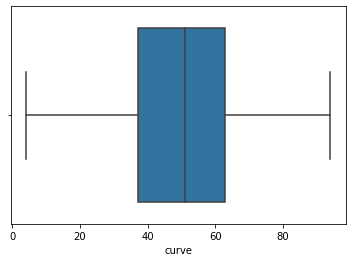

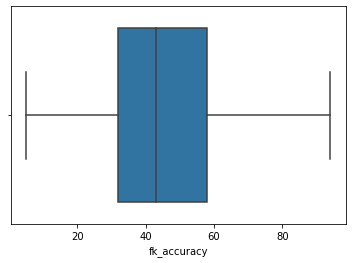

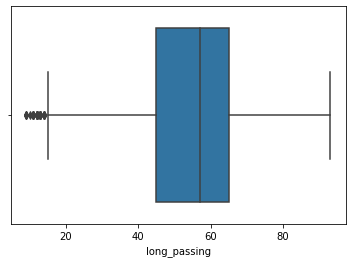

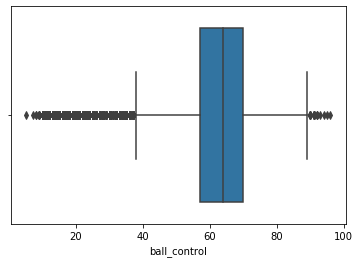

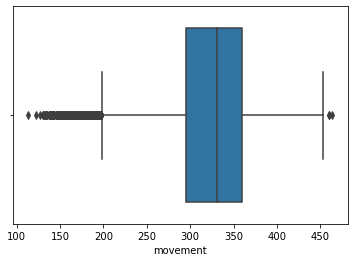

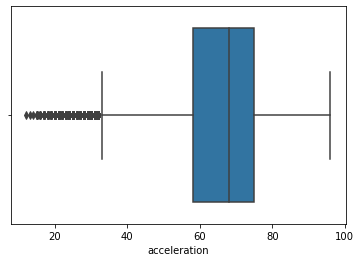

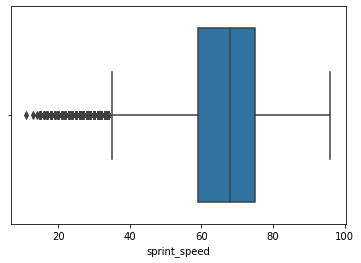

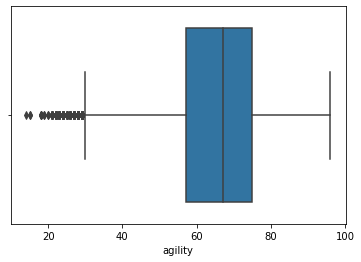

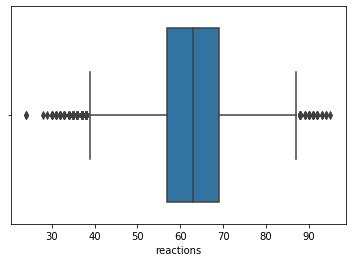

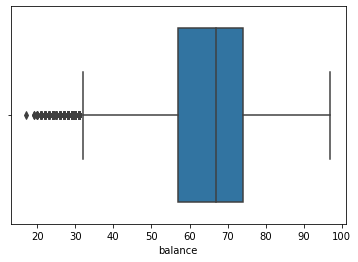

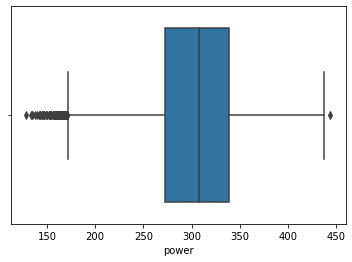

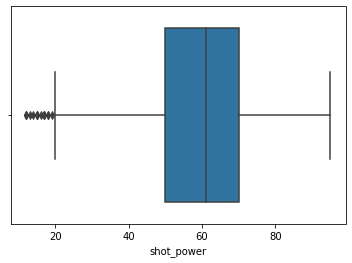

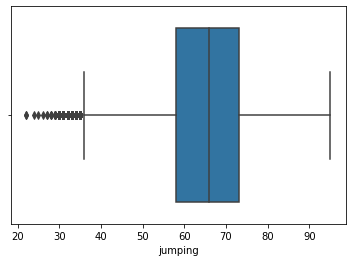

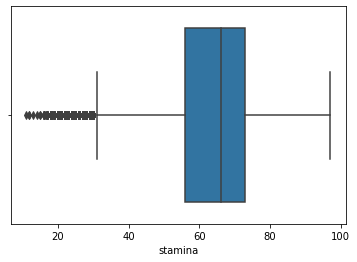

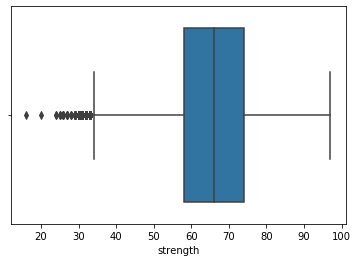

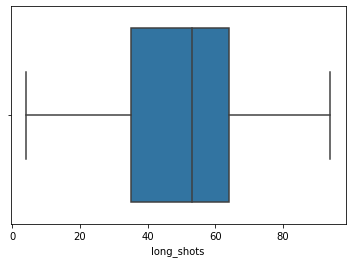

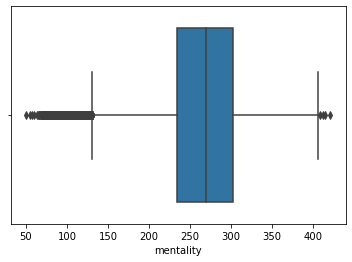

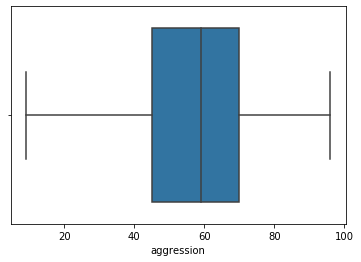

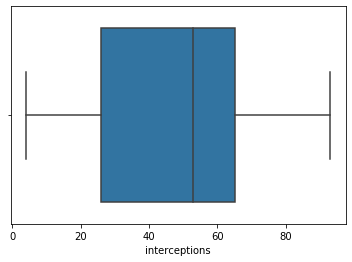

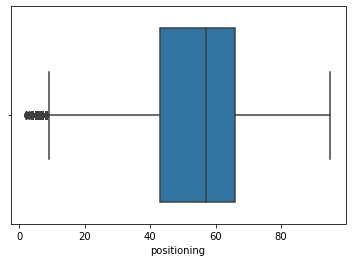

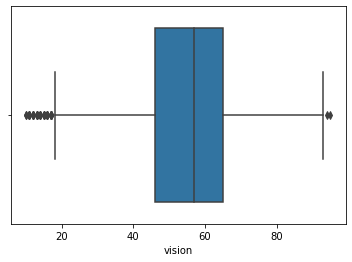

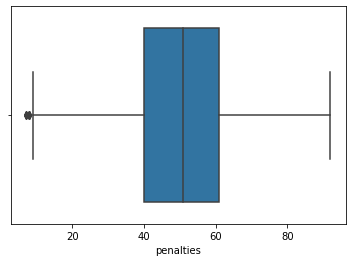

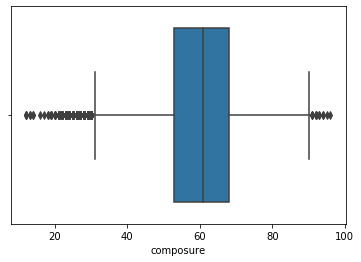

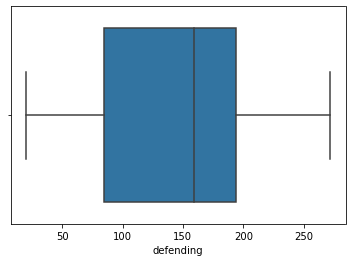

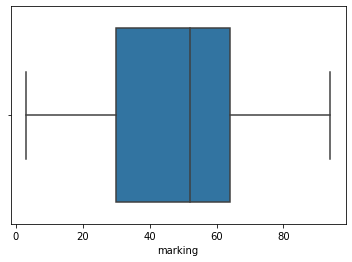

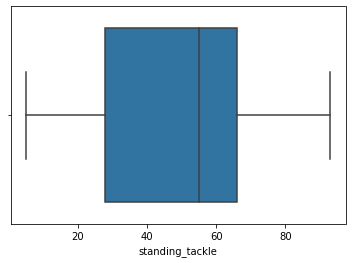

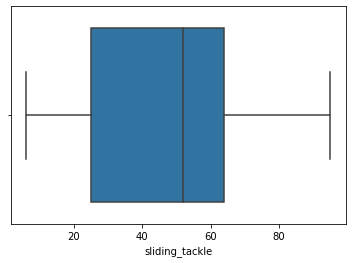

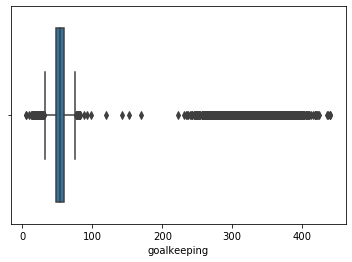

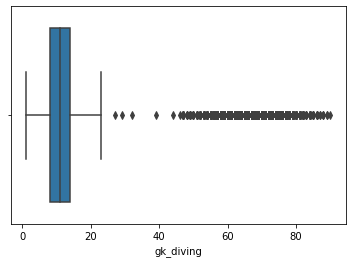

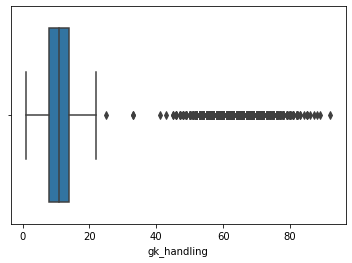

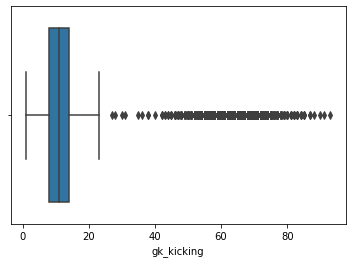

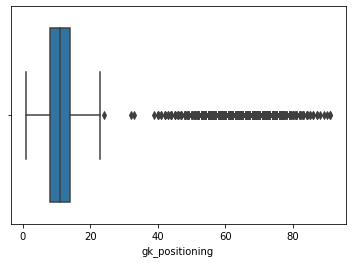

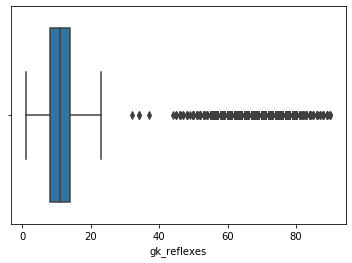

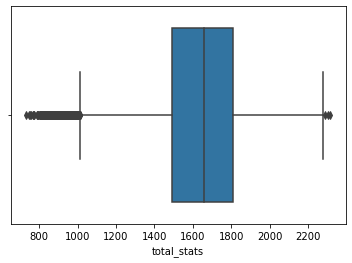

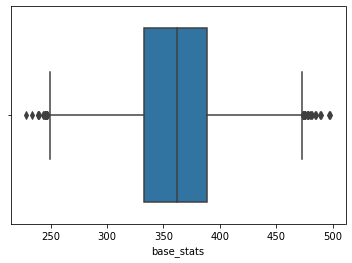

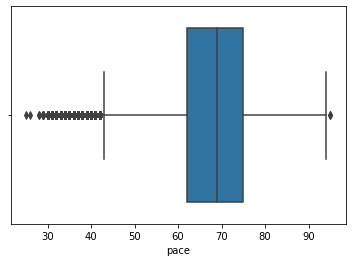

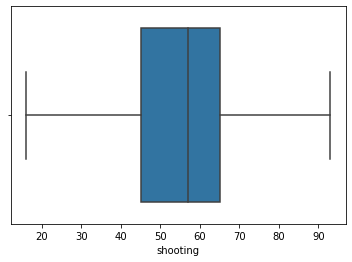

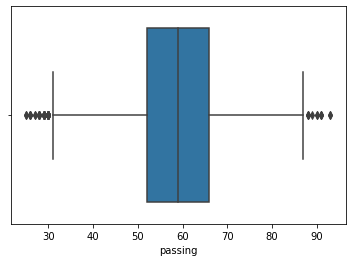

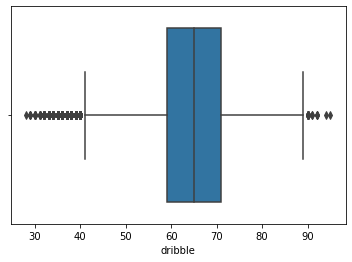

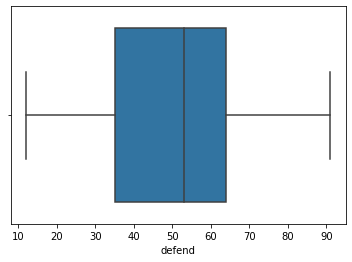

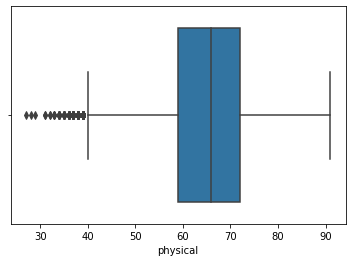

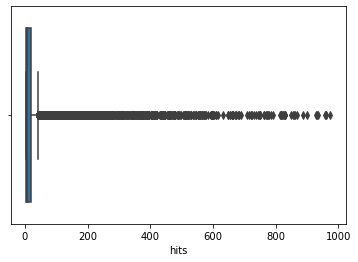

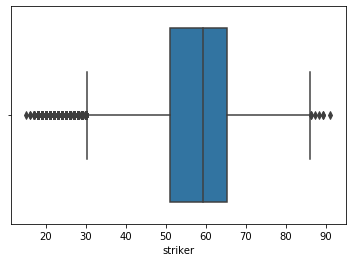

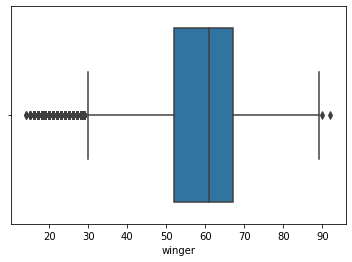

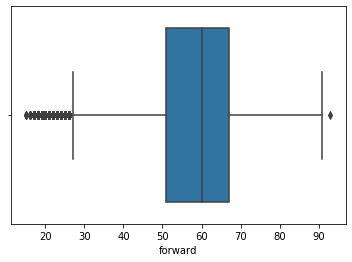

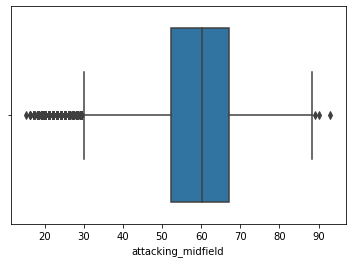

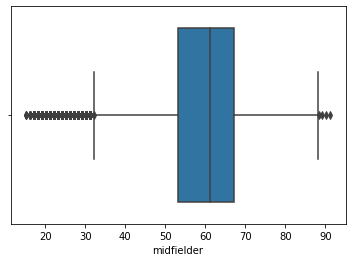

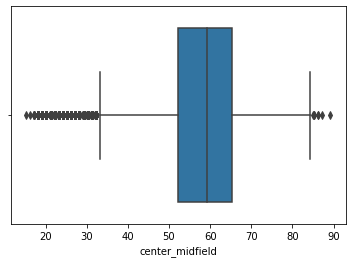

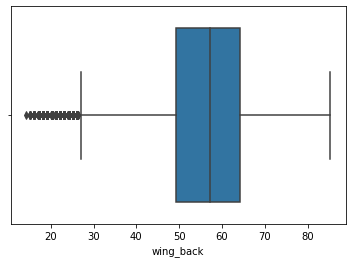

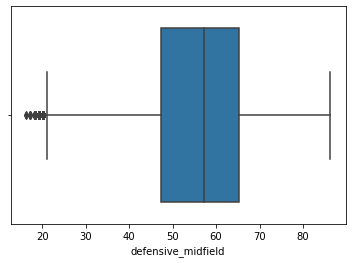

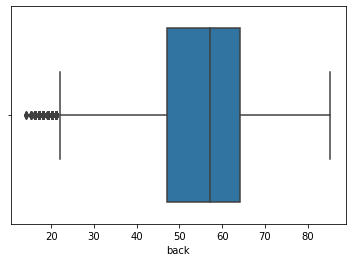

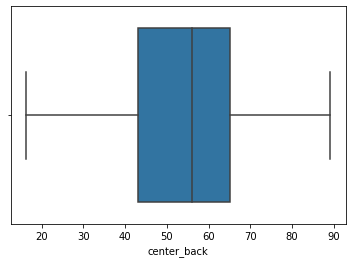

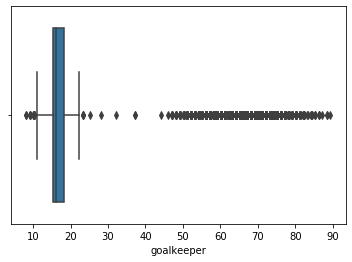

In [60]:
# Extract the continuous numerical data and plot it
for column in num.columns:
    if len(data[column].unique()) > 10:
        sns.boxplot(x=column, data=data)
        plt.show()

We can see there will be a considerable amount of outliers in:
- distributions that have two medians
* non-Gaussian distributions, e.g. `value`, `wage`, `release_clause`

#### 2.3. Correlation between different attributes

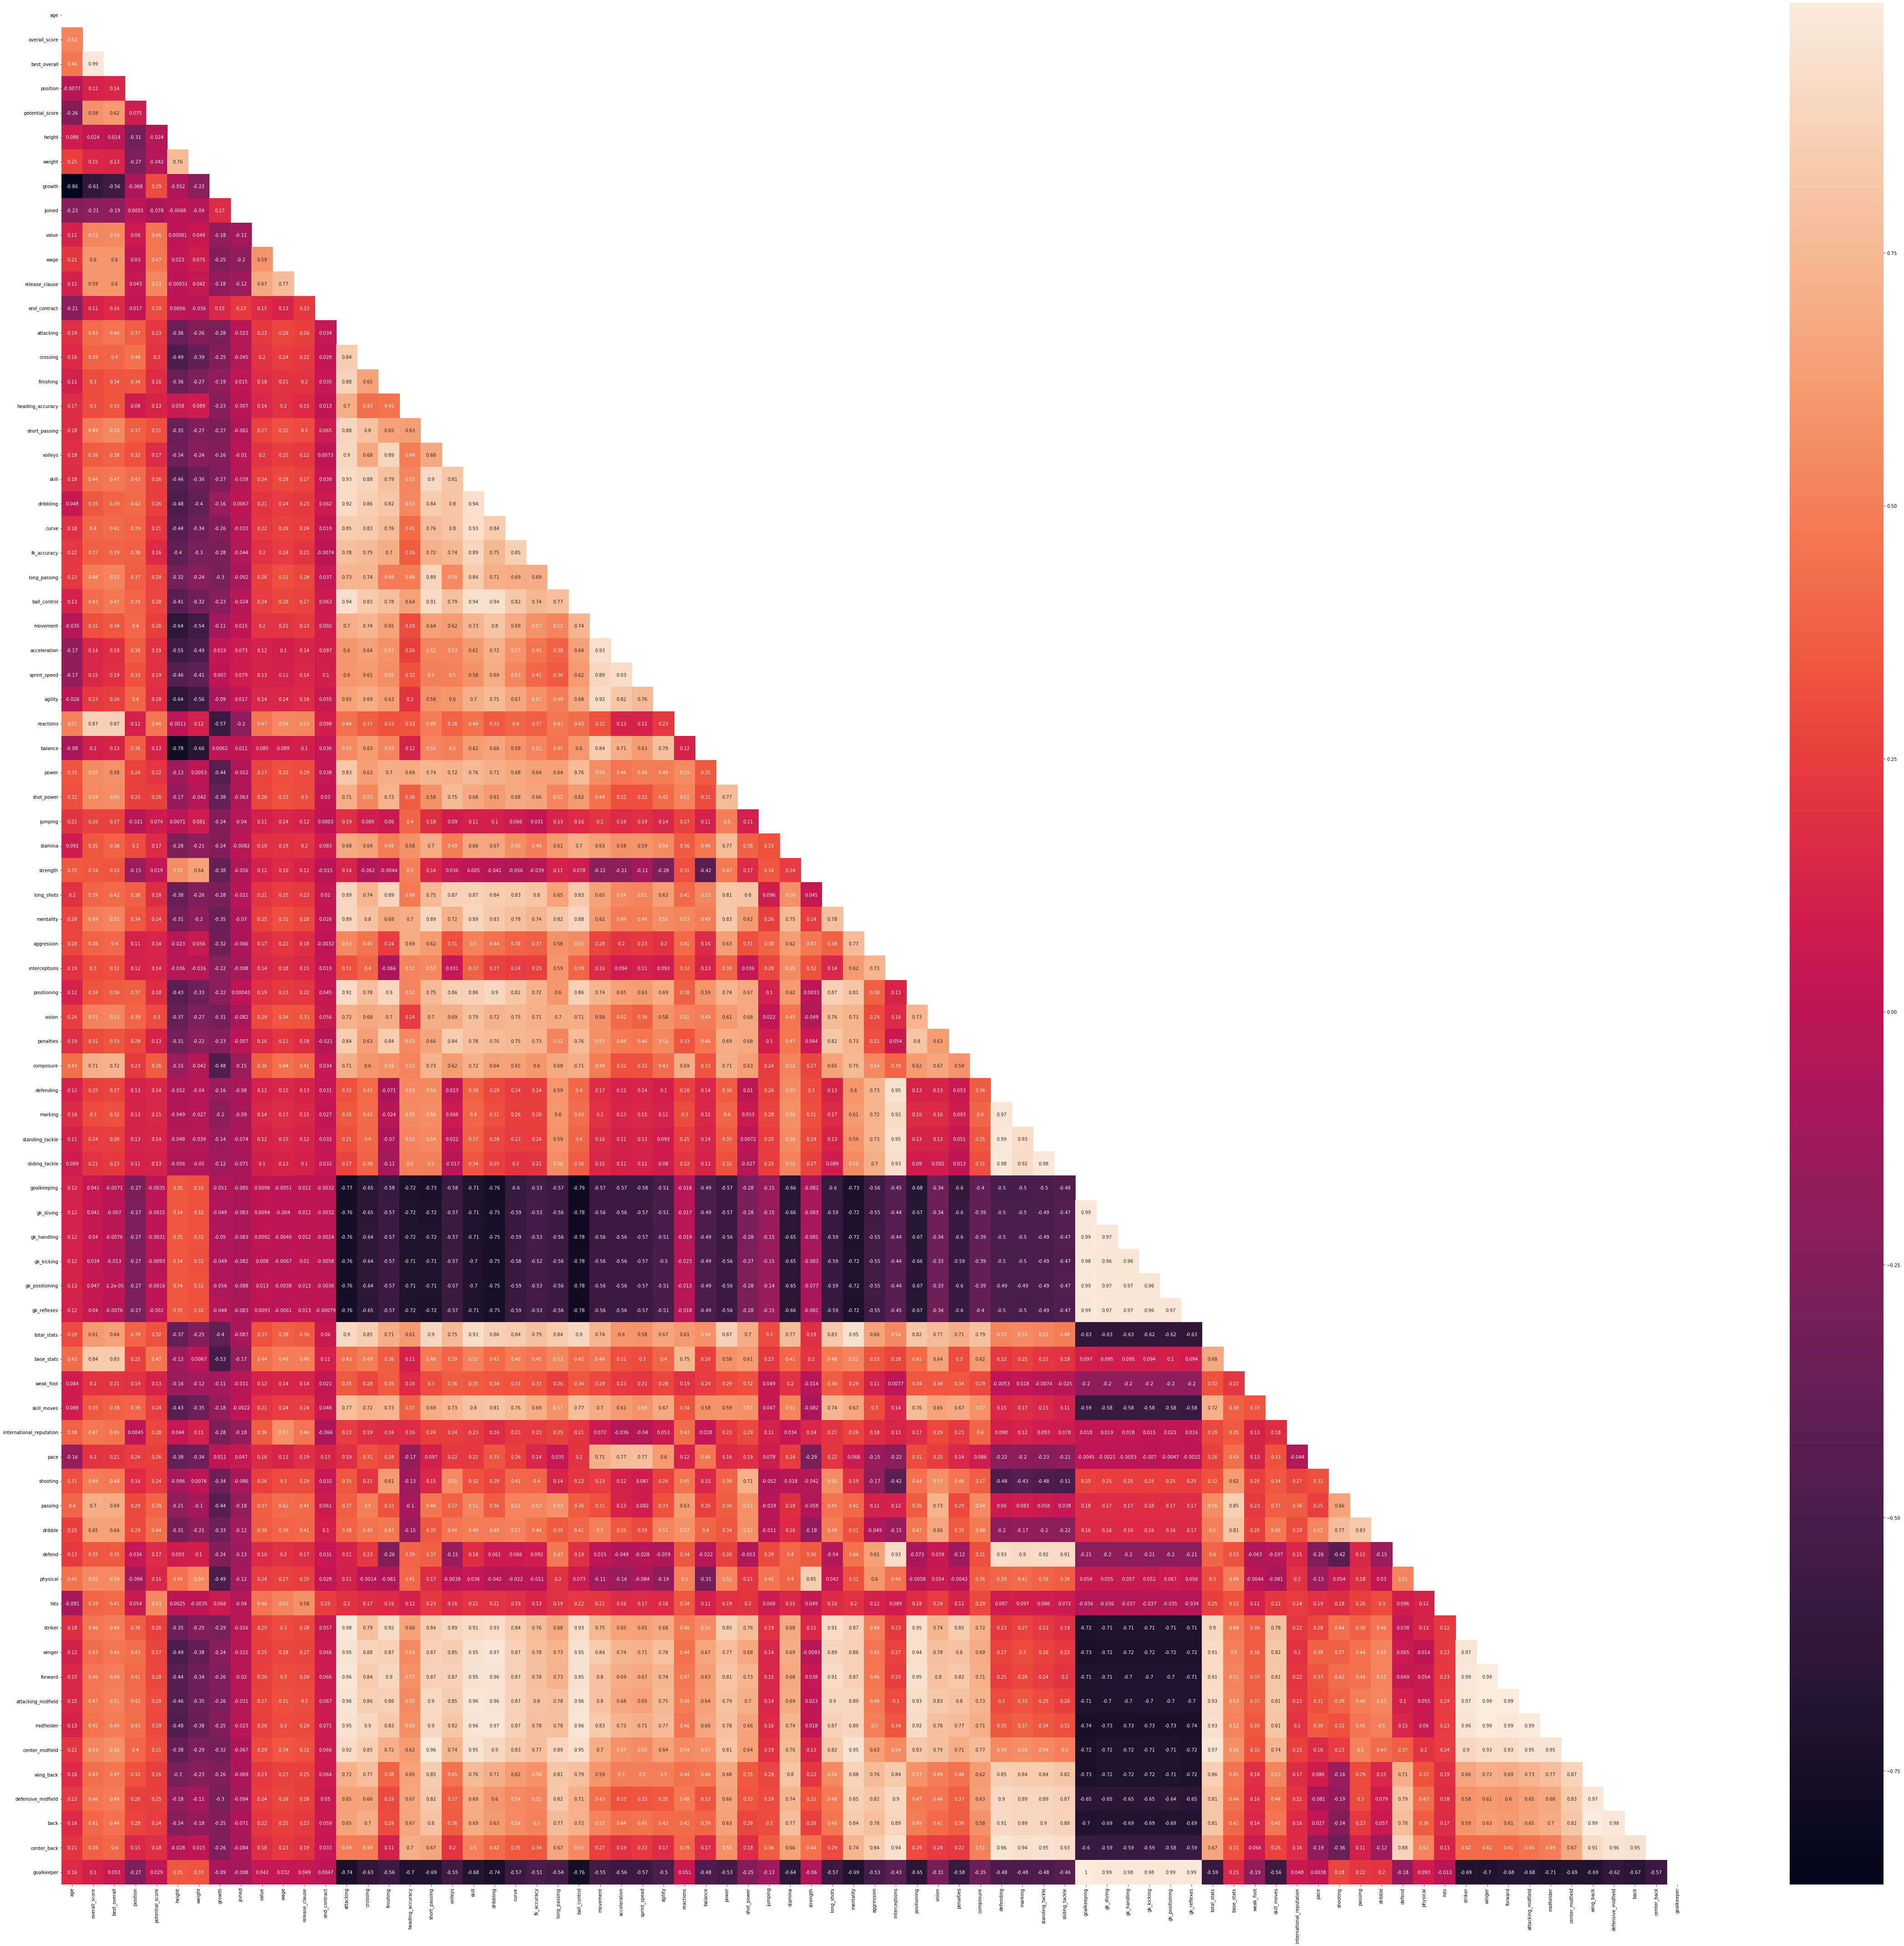

In [61]:
# Calculate correlation matrix
data.corr()

# Create heatmap
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
fig, ax = plt.subplots(figsize=(80, 76))
ax = sns.heatmap(data.corr(), mask=mask, annot=True)
plt.show()

# first observations:
# value, wage and release clause highly correlated to each other (around 0.6)
# postions very highly correlated (>0.95) to stats that fit positions, ie. attacking positions corrlated to attacking stats
  # => for the future rounds: 
    # positions and stats are highly correlated data:
    # repetition of exogenous variables can twist the model, will probably be dropped

We can notice that:
- the `goalkeeper` column is highly correlated (> 0.9) with the `goalkeeping` and `gk_[trait]` columns
* the `gk_[trait]` columns also seem to be highly correlated with each other

Therefore, we will keep only the column that is most correlated with our targets (`value`, `overall_score`), which is `goalkeeper`:

### 3. Modelling & Evaluation

#### 3.1. Define normalizing & modelling functions

##### 3.1.1. Data Scaling

In [ ]:
def normalize_data(X_num):
    transformer = MinMaxScaler().fit(X_num) 
    x_minmax = transformer.transform(X_num)
    X_num_norm = pd.DataFrame(x_minmax, columns=X_num.columns)
    return X_num_norm

##### 3.1.2. Box-Cox transformation

In [ ]:
def boxcox_transform(data):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
        data[column] = data[column].fillna(data[column].median())
        transformed_data, ci = stats.boxcox(data[column])
        data[column] = transformed_data
        _ci[column] = [ci] 
    return data, _ci

##### 3.1.3. Remove outliers

In [ ]:
def remove_outliers(columns, df, threshold=1.5):
    for column in columns:
        upper = np.percentile(df[column], 75)
        lower = np.percentile(df[column], 25)
        iqr = upper - lower
        upper_limit = upper + threshold * iqr
        lower_limit = lower - threshold * iqr
        df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df